# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [419]:
import sys

print(sys.executable)

C:\Users\bened\miniconda3\envs\DSHF3\python.exe


In [420]:
# Szükséges könyvtárak importálása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from datetime import datetime
import glob
import yfinance as yf
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

warnings.filterwarnings('ignore')

# Ábrázolási beállítások
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Könyvtárak importálva!")


Könyvtárak importálva!


Könyvtárak elérési útjai

In [421]:
data_path = Path('data/usa_stocks_data')
constituents_path = data_path / 'index/constituents'
idxperf_path = data_path / 'index/perf'
stock_prices_path = data_path / 'stock_prices'


## S&P 500

Amint látható, S&P 500 indexhez 2 fájl is található. Ezeket megvizsgálom, és a jelenlegi állapotához közelebbit használom a továbbiakban

In [422]:
sp500_companies1 = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)
sp500_companies2 = pd.read_csv(constituents_path / 'sp500_companies.csv', header=0, index_col=0)

# Szimbólumok összehasonlítása
print(f"sp500_companies.csv rekordjainak száma: {len(sp500_companies1)}")
print(f"sp500.csv rekordjainak száma: {len(sp500_companies2)}")

sp500_symbols = set(sp500_companies1['Symbol'].unique())
sp500_companies_symbols = set(sp500_companies2['Symbol'].unique())

print(f"\nSP500.csv egyedi szimbólumok száma: {len(sp500_symbols)}")
print(f"SP500_companies.csv egyedi szimbólumok száma: {len(sp500_companies_symbols)}")

# Szimbólumok, amelyek csak az egyikben vannak
only_sp500 = sp500_symbols - sp500_companies_symbols
only_sp500_companies = sp500_companies_symbols - sp500_symbols
common_symbols = sp500_symbols & sp500_companies_symbols

print(f"\nKözös szimbólumok: {len(common_symbols)}")
print(f"Csak SP500-ban lévő szimbólumokszáma: {len(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok száma: {len(only_sp500_companies)}")

print(f"\nCsak SP500-ban lévő szimbólumok: {list(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok: {list(only_sp500_companies)}")



sp500_companies.csv rekordjainak száma: 503
sp500.csv rekordjainak száma: 501

SP500.csv egyedi szimbólumok száma: 503
SP500_companies.csv egyedi szimbólumok száma: 501

Közös szimbólumok: 500
Csak SP500-ban lévő szimbólumokszáma: 3
Csak SP500_companies-ben lévő szimbólumok száma: 1

Csak SP500-ban lévő szimbólumok: ['VLTO', 'ABNB', 'BX']
Csak SP500_companies-ben lévő szimbólumok: ['NWL']


Azt, hogy nem 500 rekordot tartalmaznak a fájlok az magyarázza, hogy bizonyos cégeknek több osztályú részvénye is része a rekordoknak, pl.: GOOG (Class B), GOOGL (Class A)

In [423]:
#Attribútumok vizsgálata
print(f"\nsp500.csv oszlopok:\n {list(sp500_companies1.columns)}\n")
print(f"\nsp500_companies.csv oszlopok:\n {list(sp500_companies2.columns)}\n")


sp500.csv oszlopok:
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded', 'Shares Outstanding']


sp500_companies.csv oszlopok:
 ['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded', 'shares outstanding']



A rekordok számának viszgálatából kiderült, hogy egyik fájlban sincs duplikált adat.

Az sp500_companies.csv-ben található egyedül az NWL (Newell Brands Inc.), ami 2023 szeptember 18.-án kikerült az indexből.
Az sp500.csv-ben található egyedül 'ABNB', 'VLTO', 'BX', (Airbnb, Inc., Blackstone Inc., Veralto Corp.), amik 2023 szeptember 18.-án, és 2023 október 2.-án kerültek fel az indexre.
Ezek alapján az sp500.csv aktuálisabb információt tartalmaz.

Emellet az sp500.csv több információt tartalmaz a cégekről, és összes sp500_companies.csv-ben találhtó attribútum is jelen van.

Tehát innentől az sp500.csv-t használom az S&P 500 teljesítményének vizsgálatára.


In [424]:
sp500_companies = sp500_companies1
sp500_companies.rename()
sp500_companies.describe(include='all')

TypeError: must pass an index to rename

Adatok tisztítása

In [266]:
text_cols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location']
for col in text_cols:
    sp500_companies[col] = sp500_companies[col].astype('string').str.strip()
#Indexek közötti konzisztencia érdekében
sp500_companies.rename(columns={'GICS Sector': 'Sector'}, inplace=True)
sp500_companies.rename(columns={'GICS Sub-Industry': 'Industry'}, inplace=True)

sp500_companies['Date added'] = pd.to_datetime(sp500_companies['Date added'], errors='coerce')
sp500_companies['CIK'] = sp500_companies['CIK'].astype(int)

import re
def extract_year(x):
    if pd.isna(x):
        return pd.NA
    years = [int(y) for y in re.findall(r'(\d{4})', str(x))]
    return min(years) if years else pd.NA

sp500_companies['Founded'] = sp500_companies['Founded'].apply(extract_year)
sp500_companies['Founded'] = pd.to_numeric(sp500_companies['Founded'], errors='coerce')



print(sp500_companies.isna().sum())
print(sp500_companies[sp500_companies["Founded"].isna()].Symbol)
print(sp500_companies[sp500_companies["Date added"].isna()].Symbol)


Symbol                    0
Security                  0
Sector                    0
Industry                  1
Headquarters Location     0
Date added               12
CIK                       0
Founded                   0
Shares Outstanding        0
dtype: int64
Series([], Name: Symbol, dtype: string)
156       D
186      ES
211     FCX
243     HUM
404     ROK
415     SRE
435    TROW
445     TXN
457     USB
482      WM
490      WY
491     WHR
Name: Symbol, dtype: string


 Attribútumok vizsgálata

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               502 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             491 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(5)
memory usage: 39.3 KB


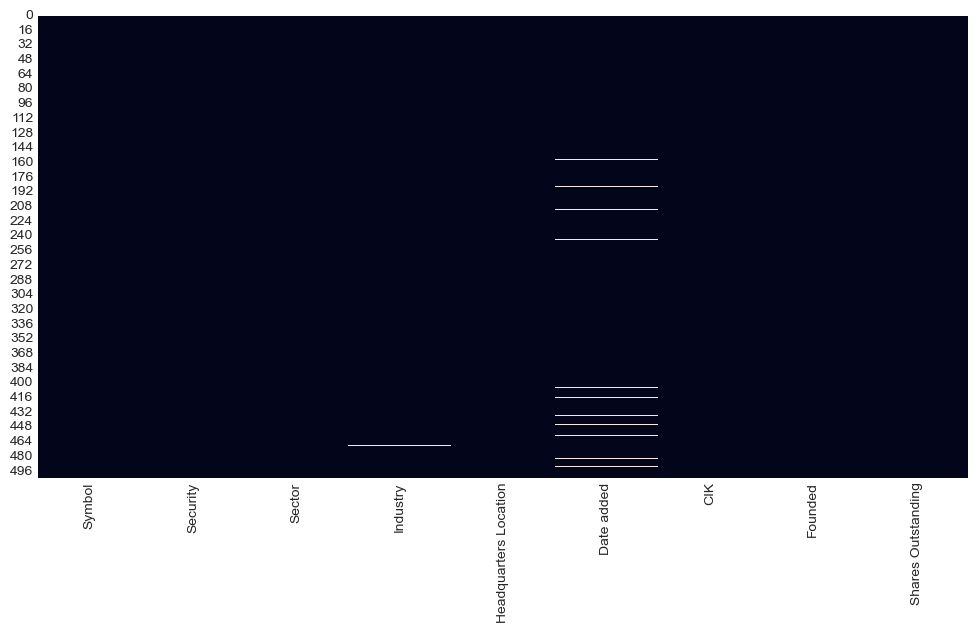

In [267]:
sp500_companies.info()
sns.heatmap(sp500_companies.isna(), cbar=False)
plt.show()

Hiányzó adatok vizsgálata

    GICS Sub-Industry

In [268]:
sp500_companies[sp500_companies["Industry"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
468,VLTO,Veralto,Industrials,<NA>,"Waltham, Massachusetts",2023-10-02,1967680,2023,246291005.0


Hiányzó adat: Environmental & Facilities Services, ennek hozzáadása

In [269]:
sp500_companies.loc[sp500_companies["Symbol"] == "VLTO", "Industry"] = "Environmental & Facilities Services"

        Date added

In [270]:
sp500_companies[sp500_companies["Date added"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
156,D,Dominion Energy,Utilities,Electric Utilities,"Richmond, Virginia",NaT,715957,1983,8.367730e+08
186,ES,Eversource,Utilities,Multi-Utilities,"Hartford, Connecticut",NaT,72741,1966,3.490860e+08
211,FCX,Freeport-McMoRan,Materials,Copper,"Phoenix, Arizona",NaT,831259,1912,1.433640e+09
243,HUM,Humana,Health Care,Managed Health Care,"Louisville, Kentucky",NaT,49071,1961,1.239070e+08
404,ROK,Rockwell Automation,Industrials,Electrical Components & Equipment,"Milwaukee, Wisconsin",NaT,1024478,1903,1.148600e+08
415,SRE,Sempra Energy,Utilities,Multi-Utilities,"San Diego, California",NaT,1032208,1998,6.293070e+08
435,TROW,T. Rowe Price,Financials,Asset Management & Custody Banks,"Baltimore, Maryland",NaT,1113169,1937,2.242950e+08
445,TXN,Texas Instruments,Information Technology,Semiconductors,"Dallas, Texas",NaT,97476,1930,9.079660e+08
457,USB,U.S. Bank,Financials,Diversified Banks,"Minneapolis, Minnesota",NaT,36104,1968,1.556970e+09
482,WM,Waste Management,Industrials,Environmental & Facilities Services,"Houston, Texas",NaT,823768,1968,4.050590e+08


Hiányzó adatok hozzáadása

In [271]:
missing_map = {
    "D":   "2016-11-30",
    "ES":  "2009-07-24",
    "FCX": "2011-07-01",
    "HUM": "2012-12-10",
    "ROK": "2000-03-12",
    "SRE": "2017-03-17",
    "TROW":"2019-07-29",
    "TXN": "2001-03-12",
    "USB": "1999-11-01",
    "WM":  "1998-08-31",
    "WY":  "1979-10-01",
    "WHR": "1959-04-01",
}

for sym, date in missing_map.items():
    sp500_companies.loc[(sp500_companies["Symbol"] == sym) & (sp500_companies["Date added"].isna()), "Date added"] = date

Kategóriás változók

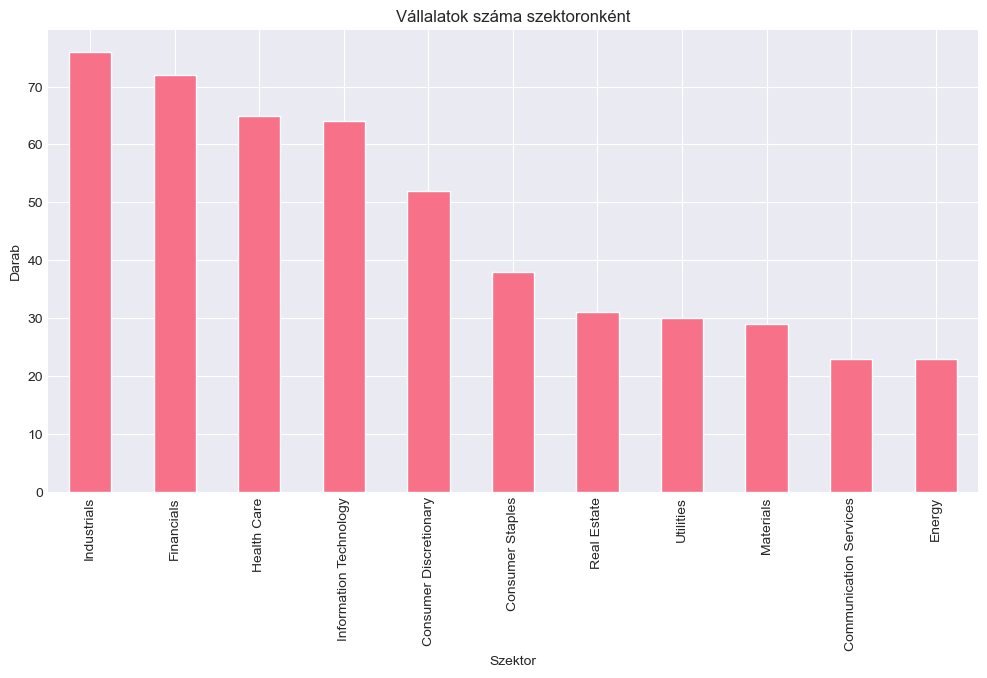

Iparágak száma: 126


In [272]:
sp500_companies['Sector'].value_counts().plot(kind='bar')
plt.title("Vállalatok száma szektoronként")
plt.ylabel("Darab")
plt.xlabel("Szektor")
plt.show()

print(f"Iparágak száma: {len(sp500_companies['Industry'].unique())}")




11 Szektorból található cég van az indexben, ami megfelel a GICS által meghatározott szektorok számának.

Sub-Industry konvertálása Industry-ra a GICS tábla alapján

In [273]:
##TODO
industry_conversion = pd.read_csv('data/industry_conversion.csv', sep=';', header=0, index_col='Sub-Industry')
industry_conversion.head()
print(f"Sub-Industry-k száma: {len(industry_conversion.index.unique())}")
print(f"Industry-k száma: {len(industry_conversion['Industry'].unique())}")
print(len(sp500_companies.Industry.unique()))

sp500_companies.loc[sp500_companies["Industry"] == "Specialty Stores", "Industry"] = "Other Specialty Retail"
#Konverzió
sp500_companies["Industry"] = sp500_companies["Industry"].map(industry_conversion["Industry"])

sp500_companies.info()

Sub-Industry-k száma: 163
Industry-k száma: 74
126
<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               503 non-null    object        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), string(4)
memory usage: 39.3+ KB


In [274]:
sp500_companies[sp500_companies["Industry"].isna()]

,Symbol,Security,Sector,Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding


In [275]:
sp500_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   Sector                 503 non-null    string        
 3   Industry               503 non-null    object        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1), string(4)
memory usage: 39.3+ KB


S&P 500 teljesítménye

Date indexként használva

In [276]:
sp500_perf = pd.read_csv(idxperf_path / 'SP500_perf.csv', parse_dates=['Date'], header=0, index_col=0)
sp500_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5+ MB


Típus konverziók

In [277]:
sp500_perf.index = pd.to_datetime(sp500_perf.index,utc=True, errors='coerce')
sp500_perf.index = sp500_perf.index.tz_convert("America/New_York")
sp500_perf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


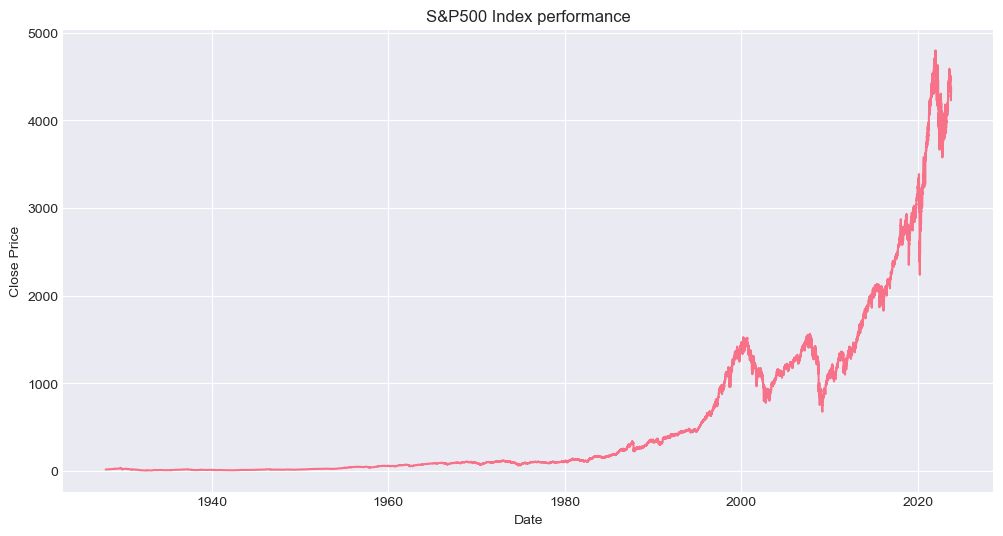

In [278]:
plt.plot(sp500_perf.index, sp500_perf["Close"])
plt.title("S&P500 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Nasdaq 100


In [279]:
nasdaq100_companies = pd.read_csv(constituents_path / 'nasdaq100_companies.csv', header=0, index_col=0)
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    object 
 1   Company Name        101 non-null    object 
 2   Industry            101 non-null    object 
 3   Sector              101 non-null    object 
 4   Founded             101 non-null    object 
 5   shares outstanding  101 non-null    float64
dtypes: float64(1), object(5)
memory usage: 5.5+ KB


Típus konverzió

In [280]:
text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    nasdaq100_companies[col] = nasdaq100_companies[col].astype('string').str.strip()

nasdaq100_companies['Founded'] = pd.to_numeric(nasdaq100_companies['Founded'], errors='coerce')


 Attribútumok vizsgálata

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             89 non-null     float64
 5   shares outstanding  101 non-null    float64
dtypes: float64(2), string(4)
memory usage: 5.5 KB


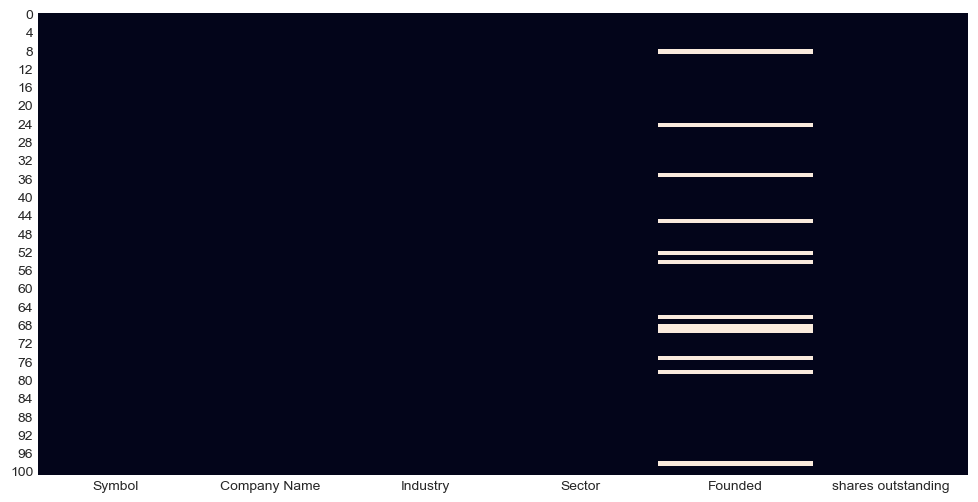

In [281]:
nasdaq100_companies.info()
sns.heatmap(nasdaq100_companies.isna(), cbar=False)
plt.show()

Hiányzó adatok hozzáadása

In [282]:
missing_map = {
    "AVGO": 1961,
    "HON":  1885,
    "MDLZ": 1903,
    "CSX":  1980,
    "MNST": 1935,
    "JD":   1998,
    "ON":   1999,
    "SGEN": 1998,
    "EXC":  2000,
    "IDXX": 1983,
    "BKR":  1908,
    "SIRI": 2008
}

for sym, date in missing_map.items():
    nasdaq100_companies.loc[(nasdaq100_companies["Symbol"] == sym) & (nasdaq100_companies["Founded"].isna()), "Founded"] = date

nasdaq100_companies['Founded'] = nasdaq100_companies['Founded'].astype(int)

In [283]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             101 non-null    int64  
 5   shares outstanding  101 non-null    float64
dtypes: float64(1), int64(1), string(4)
memory usage: 5.5 KB


Kategórikus változók

    Szektorok

Information Technology: in both
Communication Services: in both
Consumer Discretionary: in both
Consumer Staples: in both
Health Care: in both
Industrials: in both
Financials: in both
Utilities: in both
Energy: in both
Real Estate: in both
Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? True 


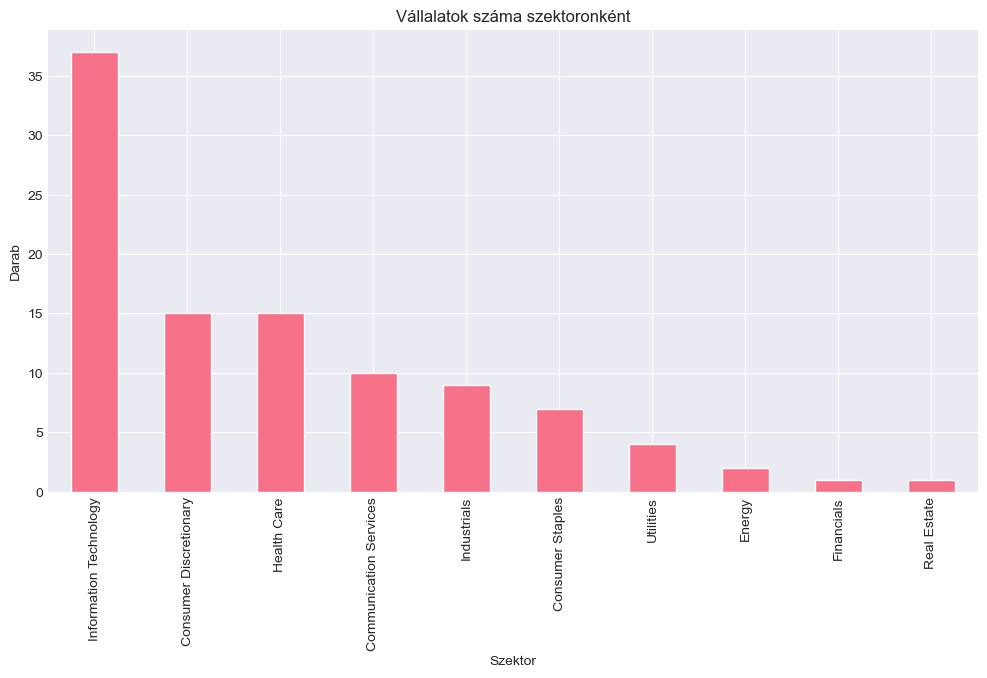

In [284]:
#Konzisztencia érdekében
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Healthcare", "Health Care")
nasdaq100_companies["Sector"] = nasdaq100_companies["Sector"].replace("Technology", "Information Technology")

for sector in nasdaq100_companies['Sector'].unique():
    if sector in sp500_companies['Sector'].unique():
        print(f"{sector}: in both")
    else:
        print(f"{sector}: only in NASDAQ 100")

print(f"Nasdaq 100 szektorai megfelelnek az S&P 500 szektorainak? "
      f"{set(nasdaq100_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")

nasdaq100_companies['Sector'].value_counts().plot(kind='bar')
plt.title("Vállalatok száma szektoronként")
plt.ylabel("Darab")
plt.xlabel("Szektor")
plt.show()



    Iparágak

In [285]:
##TODO

Nasdaq 100 teljesítménye

Date indexként használva

In [286]:
nasdaq100_perf = pd.read_csv(idxperf_path / 'Nasdaq100_perf.csv', parse_dates=['Date'], header=0, index_col=0)
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1+ KB


Típus konverziók

In [287]:
nasdaq100_perf.index = pd.to_datetime(nasdaq100_perf.index,utc=True, errors='coerce')
nasdaq100_perf.index = nasdaq100_perf.index.tz_convert("America/New_York")
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1 KB


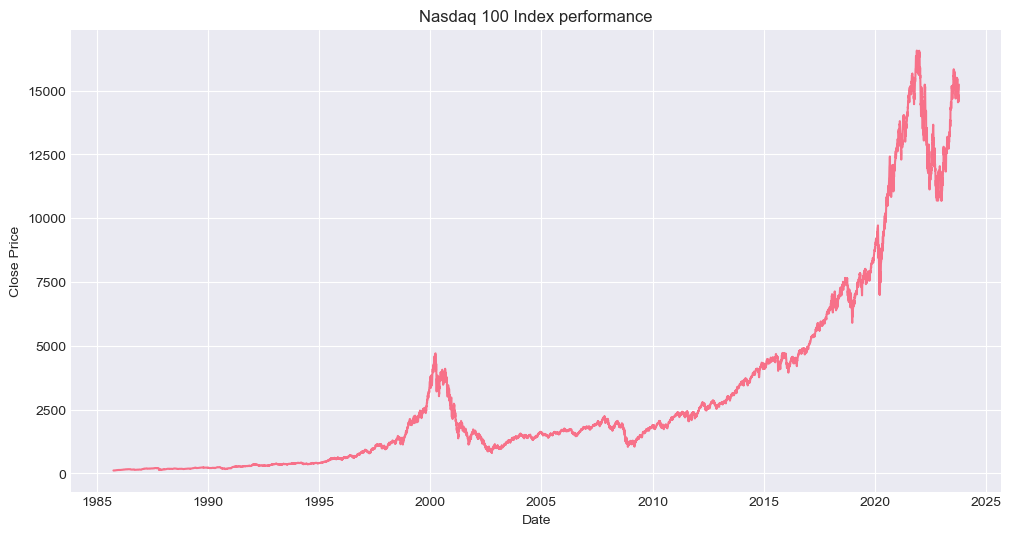

In [288]:
plt.plot(nasdaq100_perf.index, nasdaq100_perf["Close"])
plt.title("Nasdaq 100 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Dow Jones

In [289]:
dowjones_companies = pd.read_csv(constituents_path / 'dowjones_companies.csv', header=0, index_col=0)
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             101 non-null    int64  
 5   shares outstanding  101 non-null    float64
dtypes: float64(1), int64(1), string(4)
memory usage: 5.5 KB


Típus konvezió

In [290]:
text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    dowjones_companies[col] = dowjones_companies[col].astype('string').str.strip()

dowjones_companies['Founded'] = pd.to_numeric(dowjones_companies['Founded'], errors='coerce')


Attribútumok vizsgálata

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        30 non-null     string 
 1   Company Name  30 non-null     string 
 2   Industry      30 non-null     string 
 3   Sector        30 non-null     string 
 4   Founded       28 non-null     float64
dtypes: float64(1), string(4)
memory usage: 1.4 KB


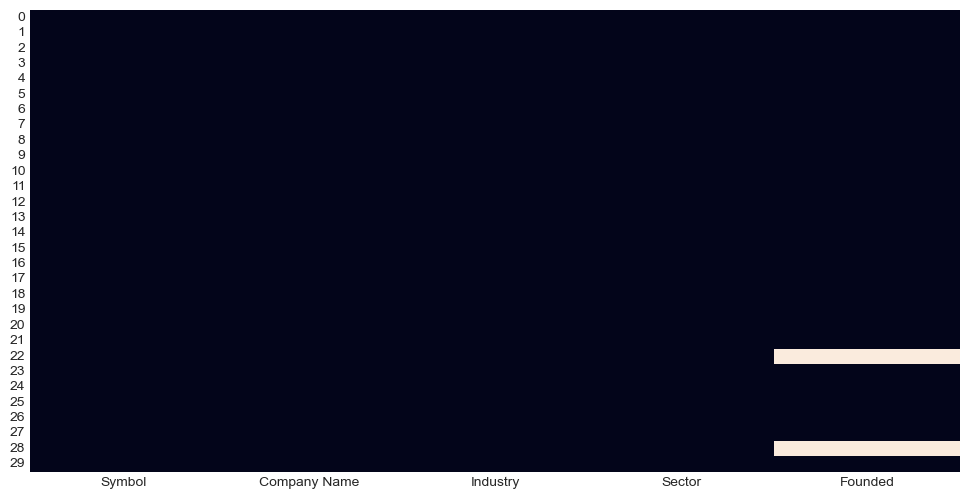

In [291]:
dowjones_companies.info()
sns.heatmap(dowjones_companies.isna(), cbar=False)
plt.show()

Hiányzó adatok hozzáadása

In [292]:
missing_map = {
    "HON": 1906,
    "DOW":  1897
}

for sym, date in missing_map.items():
    dowjones_companies.loc[(dowjones_companies["Symbol"] == sym) & (dowjones_companies["Founded"].isna()), "Founded"] = date

dowjones_companies['Founded'] = dowjones_companies['Founded'].astype(int)

dowjones_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        30 non-null     string
 1   Company Name  30 non-null     string
 2   Industry      30 non-null     string
 3   Sector        30 non-null     string
 4   Founded       30 non-null     int64 
dtypes: int64(1), string(4)
memory usage: 1.4 KB


Kategorikus változók

    Szektorok

Information Technology: in both
Financials: in both
Health Care: in both
Consumer Staples: in both
Energy: in both
Consumer Discretionary: in both
Communication Services: in both
Industrials: in both
Materials: in both
Nasdaq 100 Industry megfelelnek az S&P 500 szektorainak? True 


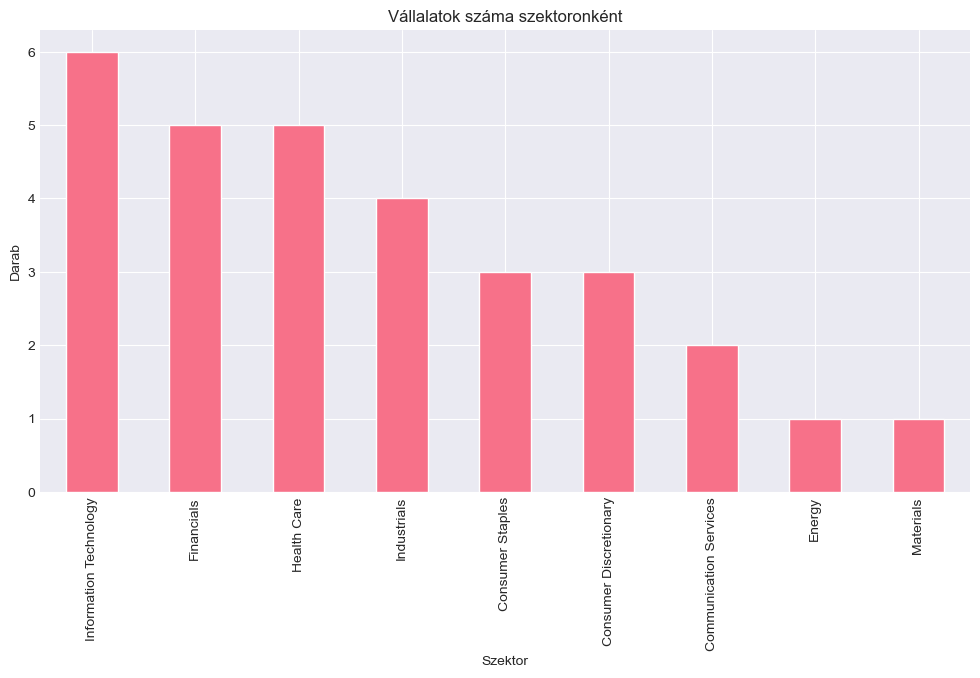

In [293]:
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Healthcare", "Health Care")
dowjones_companies["Sector"] = dowjones_companies["Sector"].replace("Technology", "Information Technology")

for sector in dowjones_companies['Sector'].unique():
    if sector in sp500_companies['Sector'].unique():
        print(f"{sector}: in both")
    else:
        print(f"{sector}: only in Dow")

print(f"Nasdaq 100 Industry megfelelnek az S&P 500 szektorainak? "
      f"{set(dowjones_companies['Sector'].unique()).issubset(set(sp500_companies['Sector'].unique()))} ")

dowjones_companies['Sector'].value_counts().plot(kind='bar')
plt.title("Vállalatok száma szektoronként")
plt.ylabel("Darab")
plt.xlabel("Szektor")
plt.show()



    Iparágak

In [294]:
##TODO

Dow Jones teljesítménye

Date indexként használva

In [295]:
dowjones_perf = pd.read_csv(idxperf_path / 'Dow_Jones_perf.csv', parse_dates=['Date'], header=0, index_col=0)
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2+ KB


Típus konverziók

In [296]:
dowjones_perf.index = pd.to_datetime(dowjones_perf.index, utc=True, errors="coerce")
dowjones_perf.index = dowjones_perf.index.tz_convert("America/New_York")
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2 KB


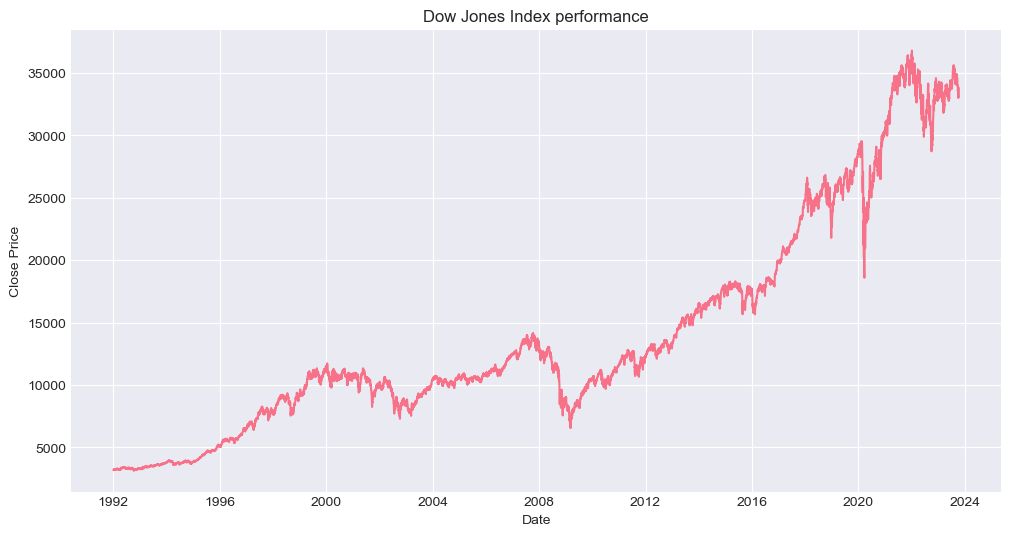

In [297]:
plt.plot(dowjones_perf.index, dowjones_perf["Close"])
plt.title("Dow Jones Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Inflációs adatok

Adatok betöltése, újraformázása későbbi felhasználhatóság érdakében
Jelenleg 1 sor = 1 év 12 hónapra és azok átlaga
Ezeket átrendezem úgy, hogy 1 sorban legyen 1 hónap inflációs adata

In [298]:
inflation_temp = pd.read_csv(data_path / 'usd_inflation.csv', parse_dates=['Year'], header=0)
inflation_temp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914-01-01,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915-01-01,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916-01-01,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917-01-01,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918-01-01,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


Adatok elforgatása könnyebb felhasználás érdekében, átlag elhagyható, később ki lehet számolni ha kell. Date inexként felhasználva

In [299]:
inflation = inflation_temp.melt(
    id_vars=["Year"],
    value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    var_name="Month",
    value_name="Inflation"
)
inflation["Year"] = pd.to_datetime(inflation["Year"]).dt.year

# dátum aggregálása egy attribútumba
inflation["Date"] = pd.to_datetime(inflation["Year"].astype(str) + "-" + inflation["Month"], format="%Y-%b")
inflation = inflation[["Date","Inflation"]].sort_values("Date").reset_index(drop=True)
inflation = inflation.set_index("Date")

# azon sorok elhagyása amikhez nincs inflációs adat (2023 vége)
inflation = inflation.dropna(subset=["Inflation"])

inflation.info()
inflation.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1316 entries, 1914-01-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Inflation  1316 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


,Inflation
Date,
1914-01-01,2.0
1914-02-01,1.0
1914-03-01,1.0
1914-04-01,0.0
1914-05-01,2.1


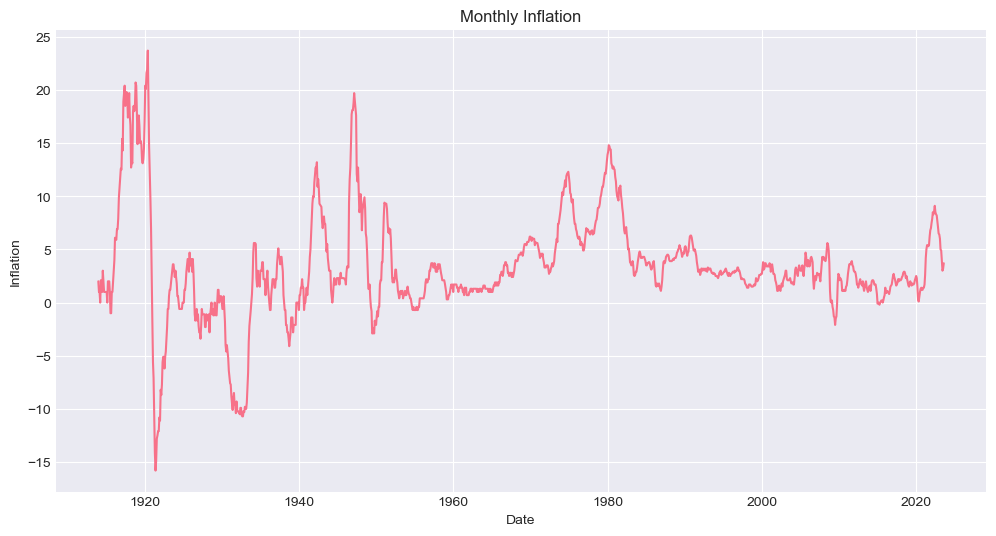

In [300]:
#plt.figure(figsize=(10,5))
plt.plot(inflation.index, inflation["Inflation"])
plt.title("Monthly Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.show()

# Részvények betöltése

Struktúra vizsgálata

In [301]:
teststock = pd.read_csv('data/usa_stocks_data/stock_prices/AAPL.csv', header=0, index_col=0)
teststock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10798 entries, 1980-12-12 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10798 non-null  float64
 1   High          10798 non-null  float64
 2   Low           10798 non-null  float64
 3   Close         10798 non-null  float64
 4   Volume        10798 non-null  int64  
 5   Dividends     10798 non-null  float64
 6   Stock Splits  10798 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 674.9+ KB


In [302]:
teststock.index = pd.to_datetime(teststock.index, utc=True, errors="coerce")
teststock.index = teststock.index.tz_convert("America/New_York")
teststock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10798 entries, 1980-12-12 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10798 non-null  float64
 1   High          10798 non-null  float64
 2   Low           10798 non-null  float64
 3   Close         10798 non-null  float64
 4   Volume        10798 non-null  int64  
 5   Dividends     10798 non-null  float64
 6   Stock Splits  10798 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 674.9 KB


In [303]:
folder = Path("data/usa_stocks_data/stock_prices/")
prices = {}# dictionary approach
stocks = []

for csv_file in folder.glob("*.csv"):
    symbol = csv_file.stem  # filename without extension
    df = pd.read_csv(csv_file, header=0, index_col=0)

    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df.index = df.index.tz_convert("America/New_York")

    # Store in dictionary
    stocks.append(symbol)
    prices[symbol] = df

# Example access:
prices['AAPL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099450,0.099882,0.099450,0.099450,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094694,0.094694,0.094261,0.094261,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087775,0.087775,0.087343,0.087343,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089504,0.089937,0.089504,0.089504,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092099,0.092532,0.092099,0.092099,73449600,0.0,0.0


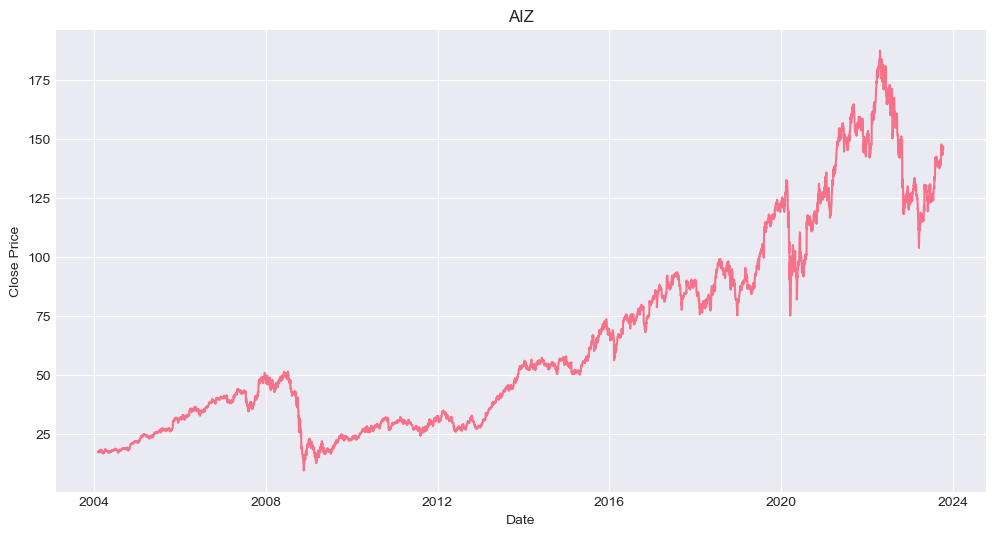

In [304]:
current_stock = stocks[18]
plt.plot(prices[current_stock].index, prices[current_stock]["Close"])
plt.title(current_stock)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


# Adatok statisztikái

S&P 500

# Statisztikák

S&P 500, NASDAQ 100, Dow Jones

    Idősor

In [358]:
indeces = {
    'S&P 500': sp500_perf,
    'Nasdaq 100': nasdaq100_perf,
    'Dow Jones': dowjones_perf
}

In [359]:
for name, idx in indeces.items():
    print(f"---{name}---")
    start = idx.index.min()
    end = idx.index.max()
    duration = end - start
    delta = idx.index.to_series().diff().value_counts().sort_index()

    print("Idősor kezdete:", start)
    print("Idősor vége:", end)
    print("Időtartam:", duration)
    print("Adatpontok száma:", len(idx))
    print("Adatok részletessége: ", min(delta), "nap")

---S&P 500---
Idősor kezdete: 1927-12-30 00:00:00-05:00
Idősor vége: 2023-10-11 00:00:00-04:00
Időtartam: 34983 days 23:00:00
Adatpontok száma: 24060
Adatok részletessége:  1 nap
---Nasdaq 100---
Idősor kezdete: 1985-10-01 00:00:00-04:00
Idősor vége: 2023-10-11 00:00:00-04:00
Időtartam: 13889 days 00:00:00
Adatpontok száma: 9585
Adatok részletessége:  1 nap
---Dow Jones---
Idősor kezdete: 1992-01-02 00:00:00-05:00
Idősor vége: 2023-10-11 00:00:00-04:00
Időtartam: 11604 days 23:00:00
Adatpontok száma: 8004
Adatok részletessége:  1 nap


    Éves átlagos hozam

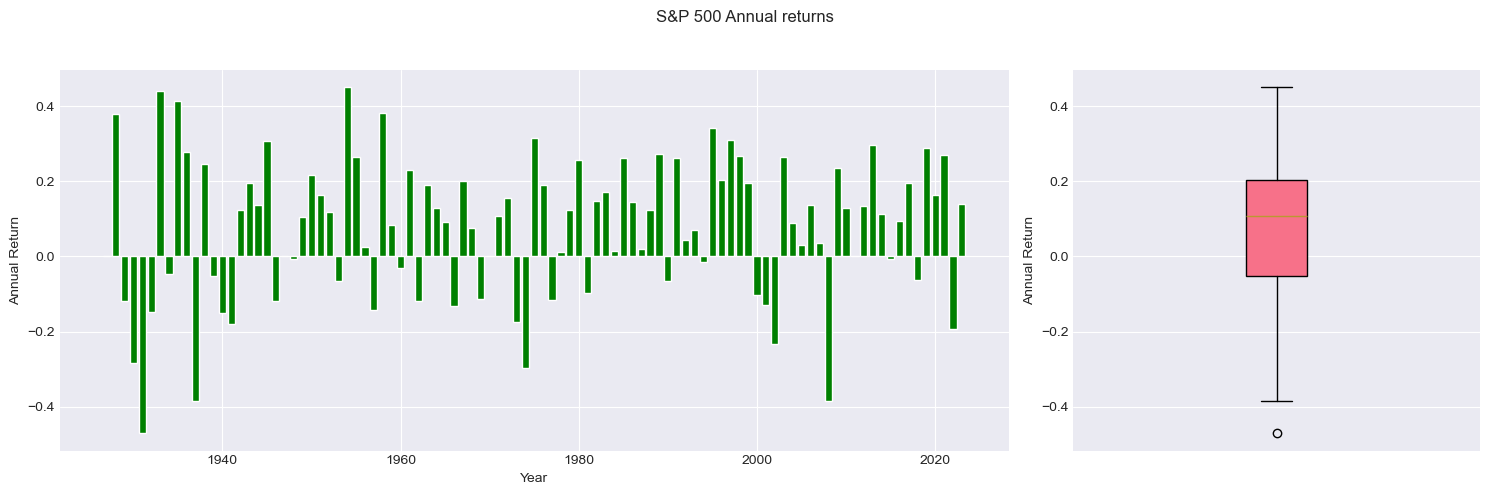

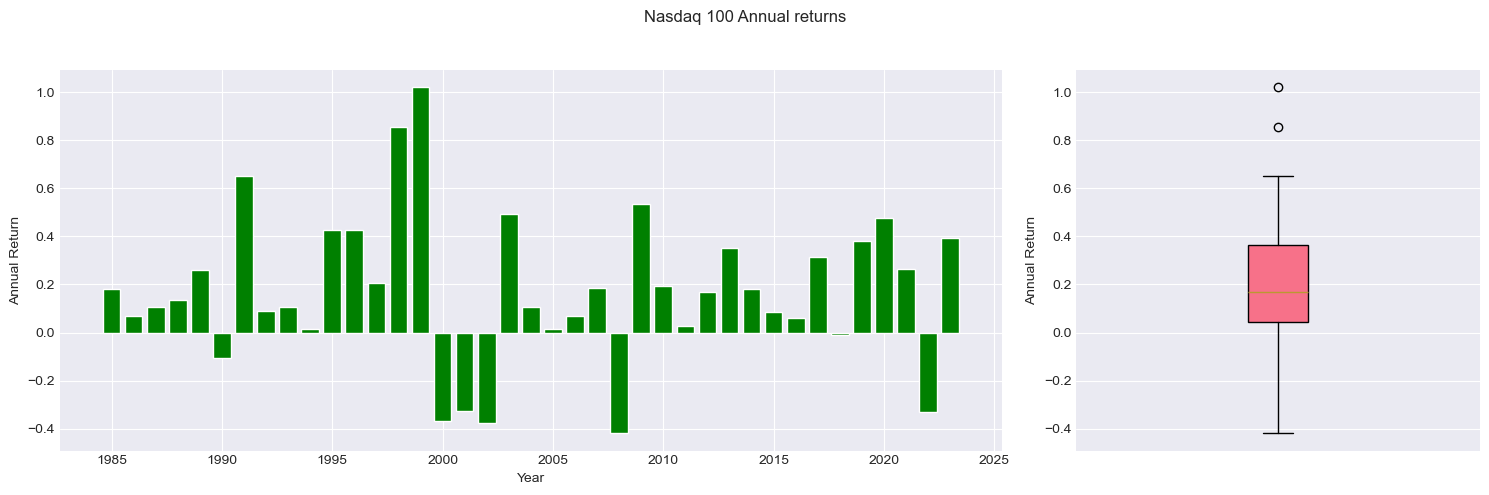

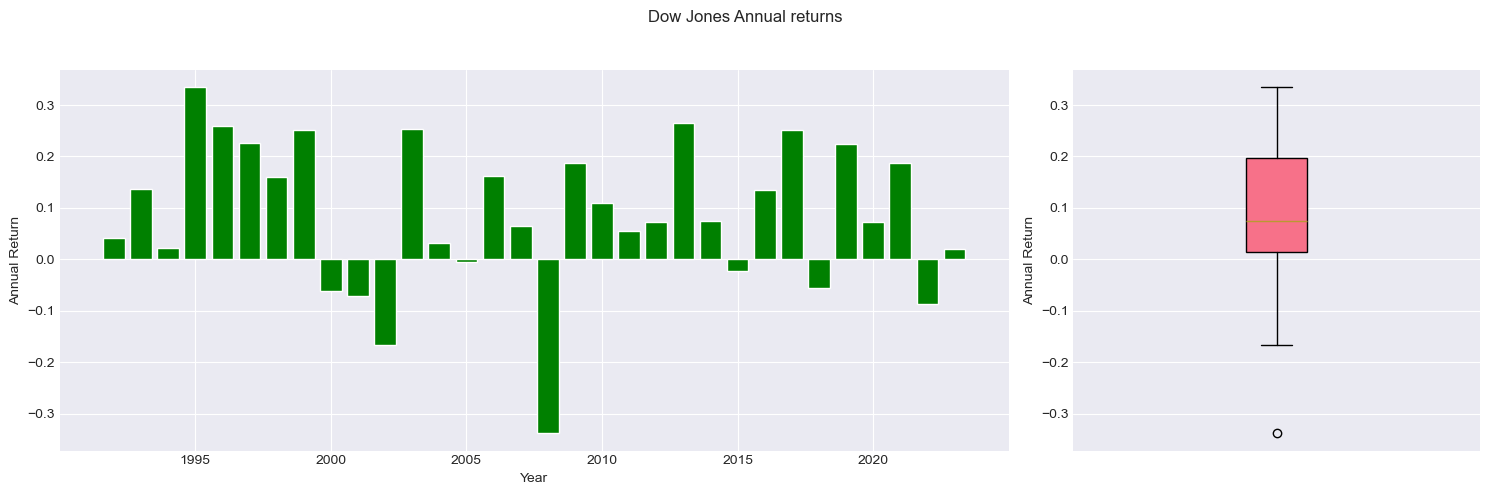

In [427]:
for name, idx in indeces.items():
    idx['Return'] = idx['Close'].pct_change()
    annual_return = (1 + idx['Return']).resample('Y').prod() - 1

    fig, axs = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [7, 3]})
    fig.suptitle(f"{name} Annual returns")

    axs[0].bar(annual_return.index.year, annual_return.values, color='green')
    axs[0].set_xlabel("Year")
    axs[0].set_ylabel("Annual Return")
    axs[0].grid(True, axis='y')

    axs[1].boxplot(annual_return.values, vert=True, patch_artist=True)
    axs[1].set_ylabel("Annual Return")
    axs[1].set_xticks([])  # Hide x-axis ticks since it’s just one box
    axs[1].grid(True, axis='y')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()




    Havi volatilitás

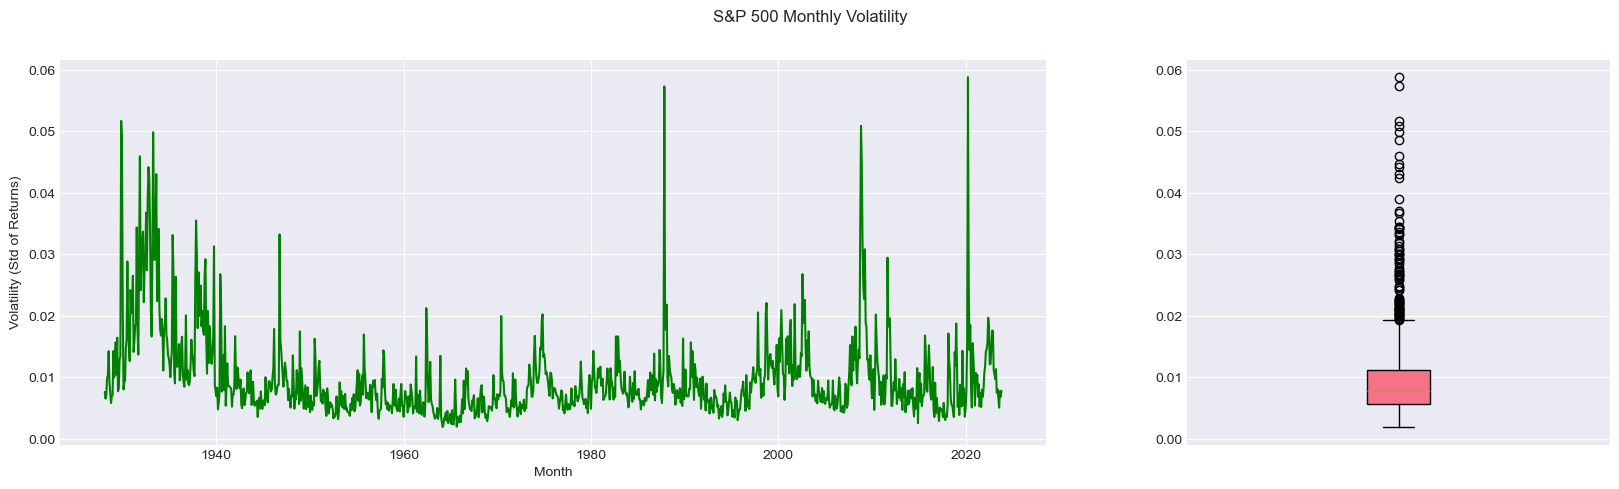

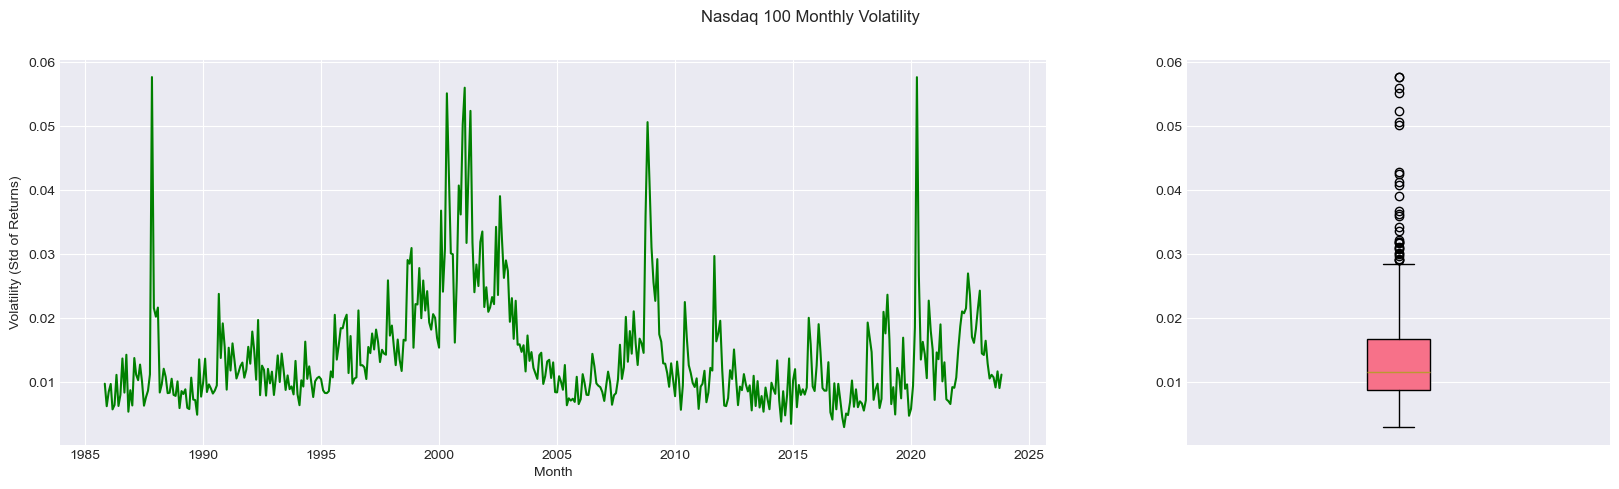

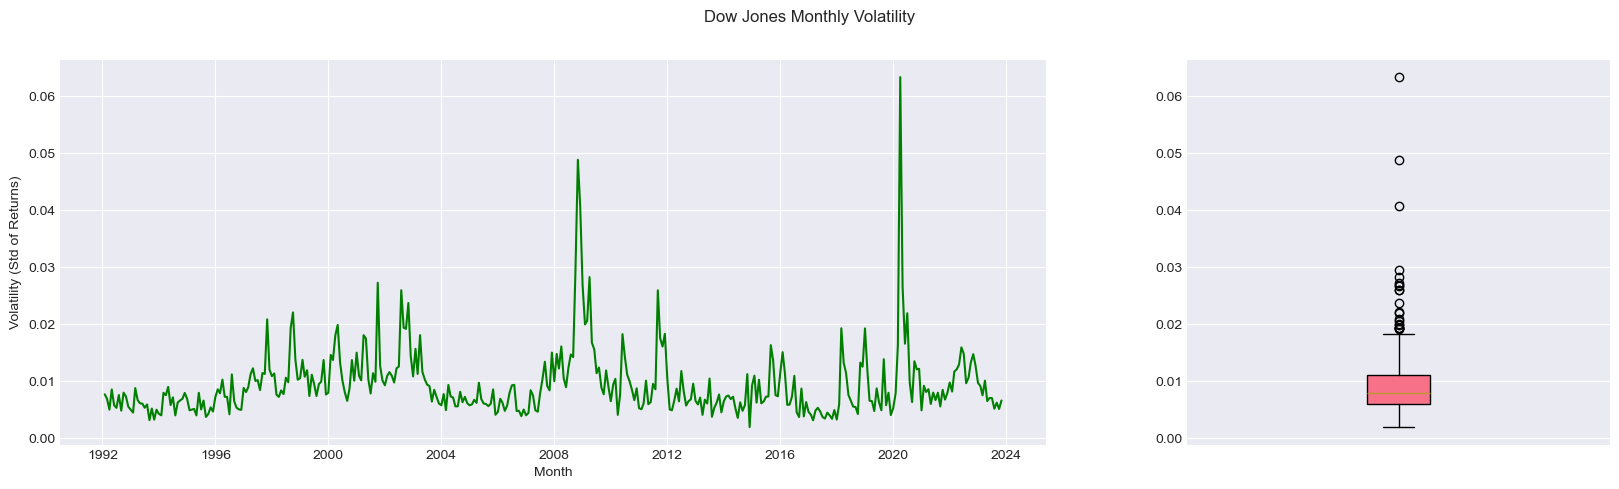

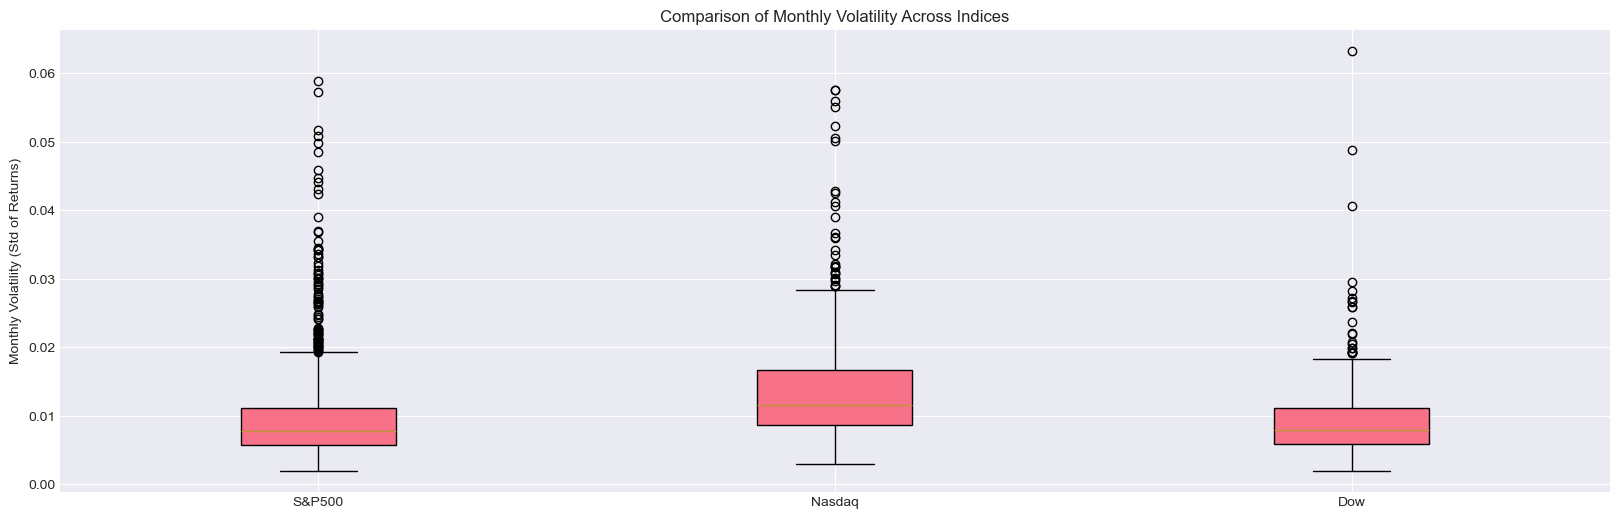

In [437]:
for name, idx in indeces.items():
    monthly_vol = idx['Return'].resample('M').std()
    monthly_vol = monthly_vol.dropna()

    fig, axs = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios': [7, 3]})
    fig.suptitle(f"{name} Monthly Volatility")

    axs[0].plot(monthly_vol.index, monthly_vol.values, color='green')
    axs[0].set_xlabel("Month")
    axs[0].set_ylabel("Volatility (Std of Returns)")
    axs[0].grid(True, axis='y')

    axs[1].boxplot(monthly_vol.values, vert=True, patch_artist=True)
    axs[1].set_xticks([])
    axs[1].grid(True, axis='y')
    plt.show()

monthly_vols = {
    'S&P500': sp500_perf['Return'].resample('M').std().dropna(),
    'Nasdaq': nasdaq100_perf['Return'].resample('M').std().dropna(),
    'Dow': dowjones_perf['Return'].resample('M').std().dropna()
}
data = [v.values for v in monthly_vols.values()]
plt.figure(figsize=(20,6))
plt.boxplot(data, vert=True, patch_artist=True, labels=monthly_vols.keys())

plt.ylabel("Monthly Volatility (Std of Returns)")
plt.title("Comparison of Monthly Volatility Across Indices")
plt.grid(True, axis='y')
plt.show()

pricechange/vol/volume by weekday

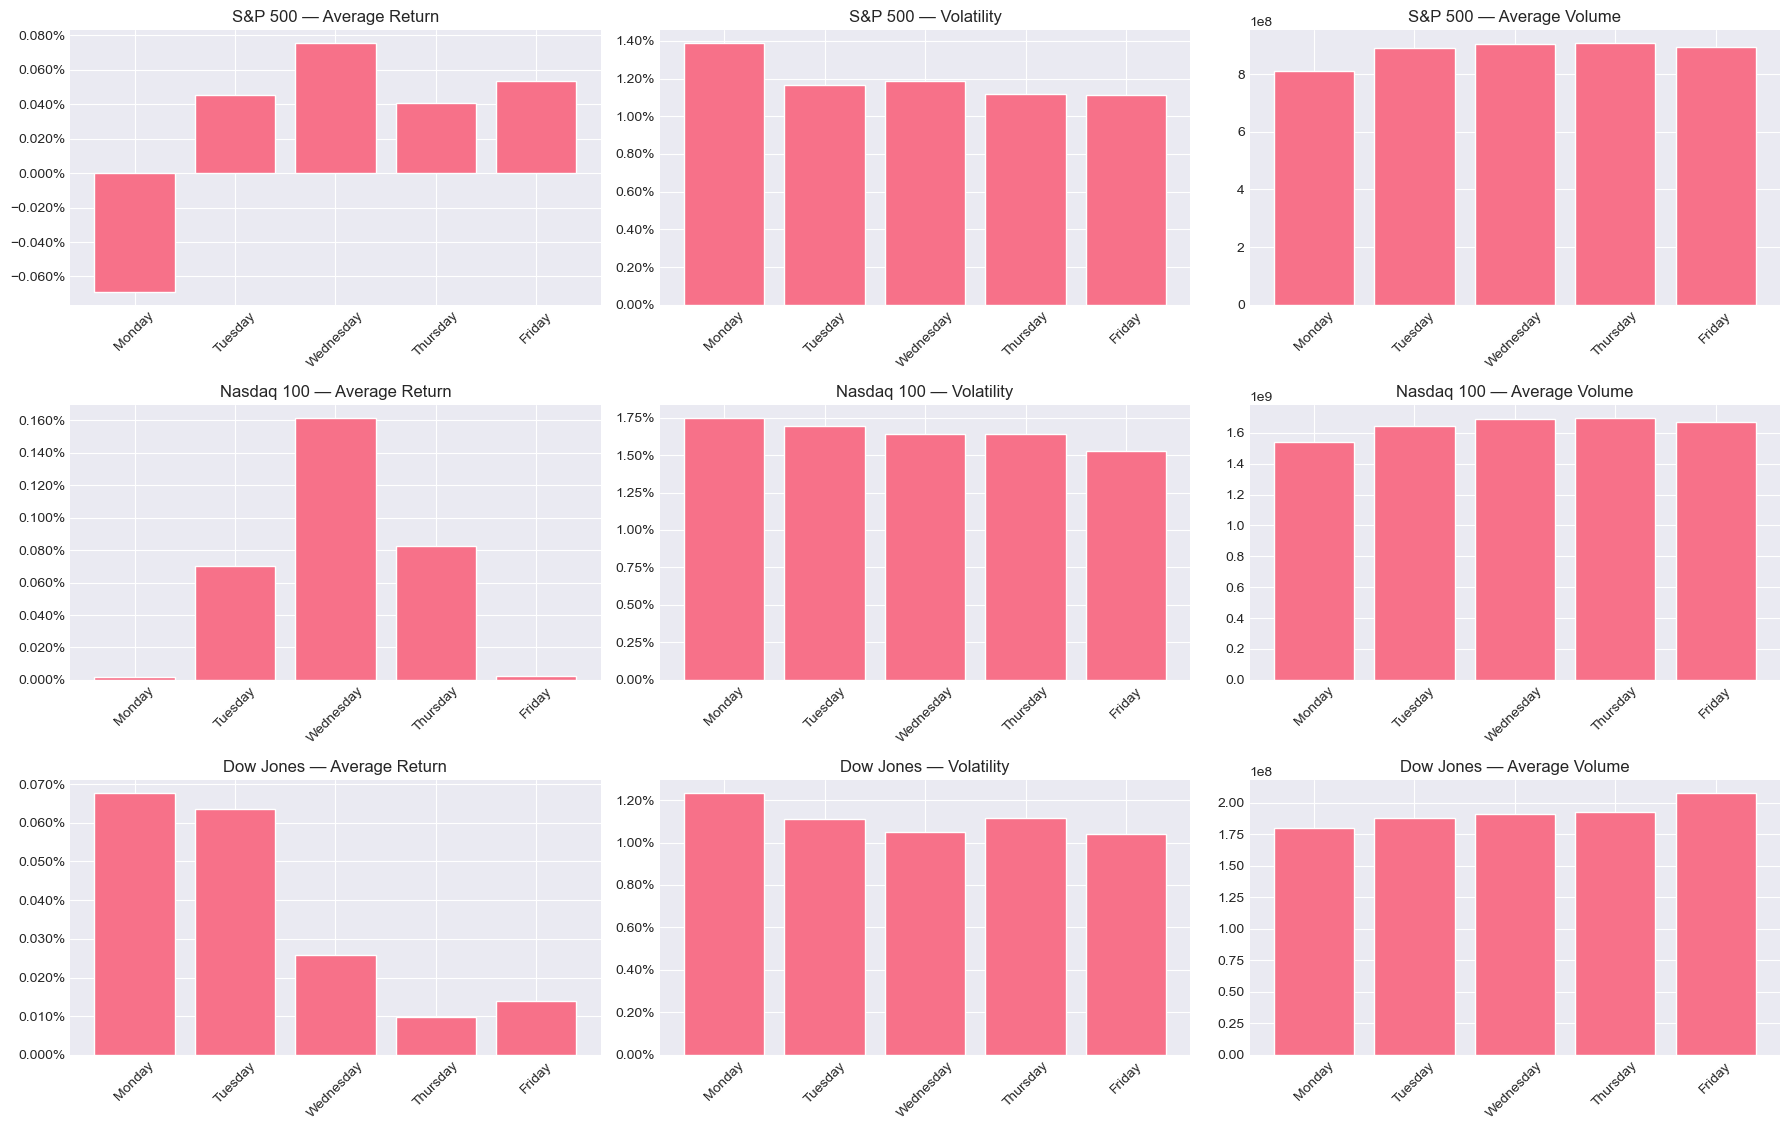

In [466]:
import calendar
import matplotlib.ticker as mtick

x = 200 # number of years to include

weekday_avg = {}
weekday_volatility = {}
weekday_volume = {}

for name, idx in indeces.items():
    # Determine the last x years
    all_years = idx.index.year.unique()
    last_years = all_years[-x:] if len(all_years) >= x else all_years

    # Filter the index to these years
    idx_recent = idx[idx.index.year.isin(last_years)].copy()
    idx_recent['Day'] = idx_recent.index.weekday

    # Weekday metrics
    average = idx_recent.groupby('Day')['Return'].mean()
    volatility = idx_recent.groupby('Day')['Return'].std()
    volume = idx_recent.groupby('Day')['Volume'].mean()

    # Map numeric day to day names
    average.index = average.index.map(lambda d: calendar.day_name[d])
    volatility.index = volatility.index.map(lambda d: calendar.day_name[d])
    volume.index = volume.index.map(lambda d: calendar.day_name[d])

    weekday_avg[name] = average
    weekday_volatility[name] = volatility
    weekday_volume[name] = volume

index_names = list(weekday_avg.keys())
weekdays = weekday_avg[index_names[0]].index  # weekday labels

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

metrics = [
    ("Average Return", weekday_avg, True),
    ("Volatility", weekday_volatility, True),
    ("Average Volume", weekday_volume, False)
]

for i, idx_name in enumerate(index_names):
    for j, (metric_name, metric_dict, is_percent) in enumerate(metrics):
        ax = axs[i, j]
        values = metric_dict[idx_name].values

        ax.bar(weekdays, values)
        ax.set_title(f"{idx_name} — {metric_name}")
        ax.set_xticklabels(weekdays, rotation=45)
        ax.grid(True, axis='y')

        if is_percent:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


pricechange/vol/volume by month


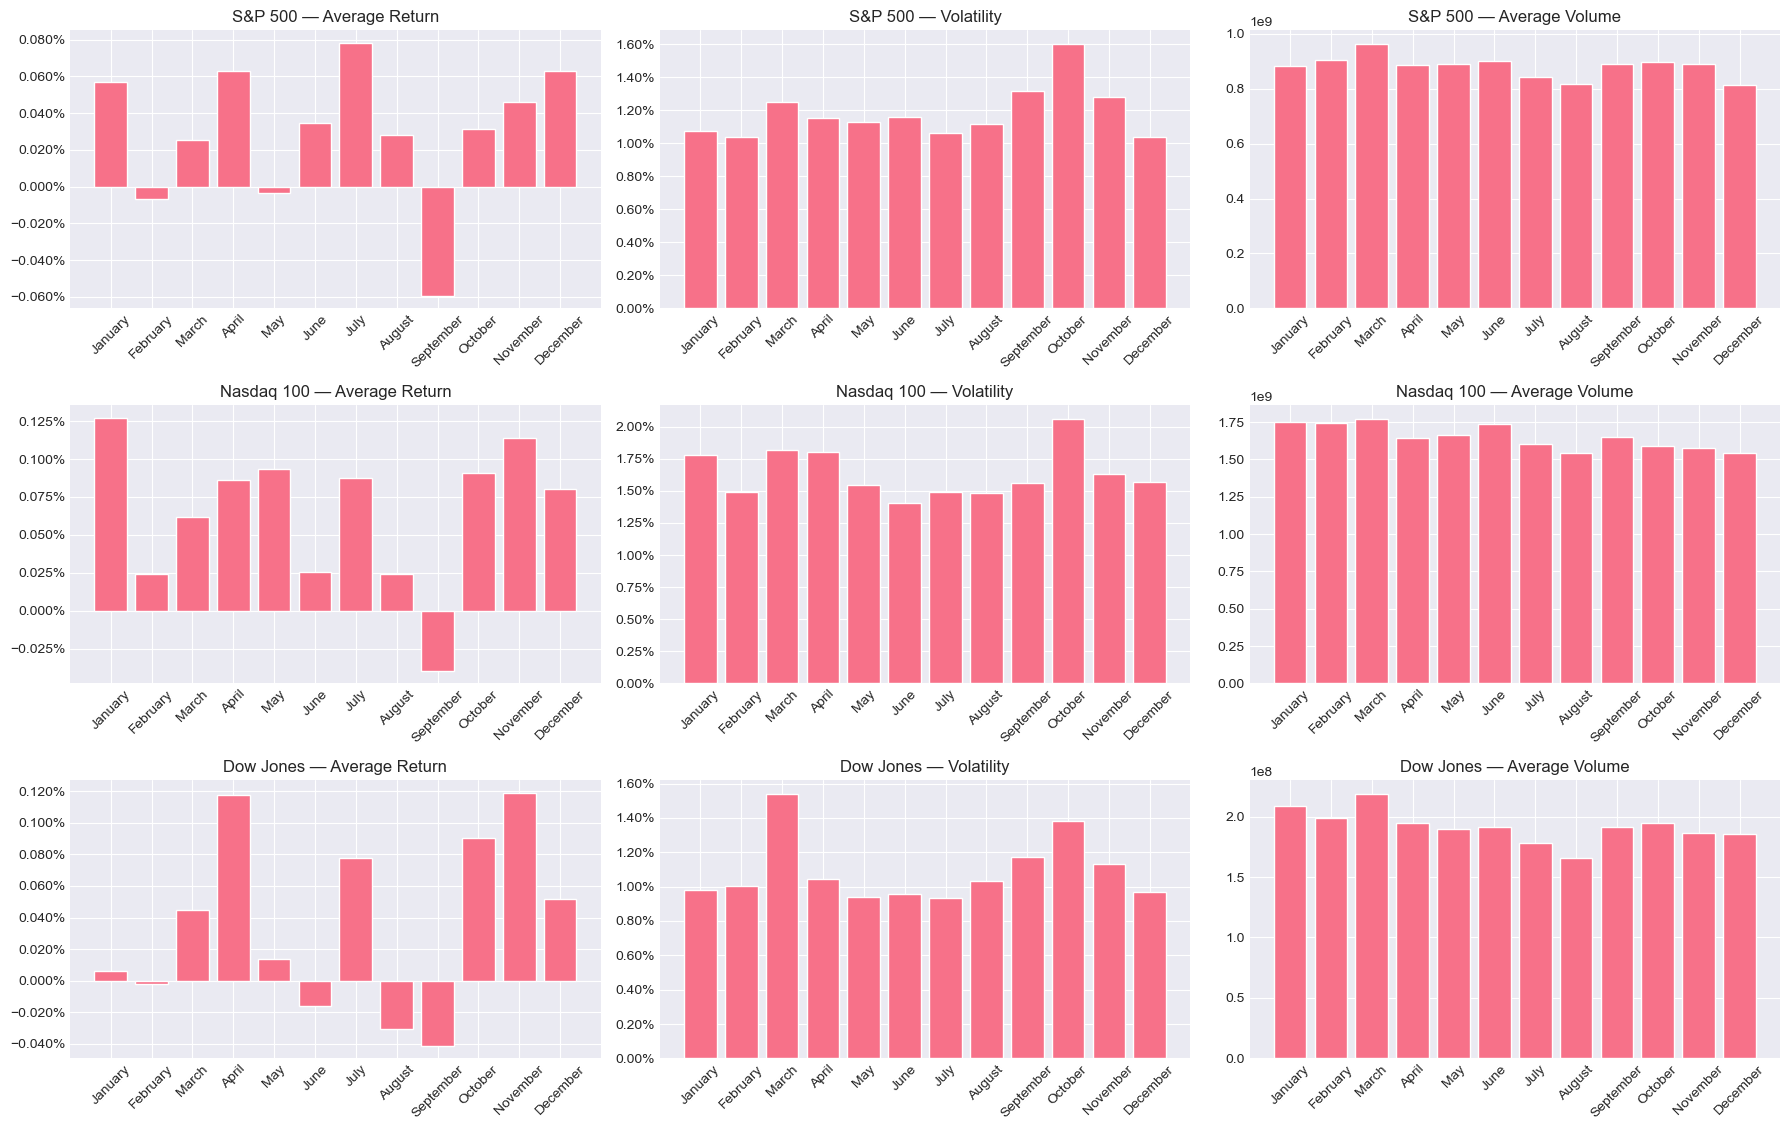

In [463]:
import calendar
import matplotlib.ticker as mtick

x = 200  # number of years to look back

month_avg = {}
month_volatility = {}
month_volume = {}

for name, idx in indeces.items():
    # Determine the last x years
    all_years = idx.index.year.unique()
    last_years = all_years[-x:] if len(all_years) >= x else all_years

    # Filter the index to these years
    idx_recent = idx[idx.index.year.isin(last_years)].copy()
    idx_recent['Month'] = idx_recent.index.month

    # Monthly metrics
    average = idx_recent.groupby('Month')['Return'].mean()
    volatility = idx_recent.groupby('Month')['Return'].std()
    volume = idx_recent.groupby('Month')['Volume'].mean()

    # Replace numeric month index with month names
    average.index = average.index.map(lambda m: calendar.month_name[m])
    volatility.index = volatility.index.map(lambda m: calendar.month_name[m])
    volume.index = volume.index.map(lambda m: calendar.month_name[m])

    month_avg[name] = average
    month_volatility[name] = volatility
    month_volume[name] = volume

index_names = list(month_avg.keys())
months = month_avg[index_names[0]].index  # month labels

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

metrics = [
    ("Average Return", month_avg, True),
    ("Volatility", month_volatility, True),
    ("Average Volume", month_volume, False)
]

for i, idx_name in enumerate(index_names):
    for j, (metric_name, metric_dict, is_percent) in enumerate(metrics):
        ax = axs[i, j]
        values = metric_dict[idx_name].values

        ax.bar(months, values)
        ax.set_title(f"{idx_name} — {metric_name}")
        ax.set_xticklabels(months, rotation=45)
        ax.grid(True, axis='y')

        if is_percent:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


most volatile years/

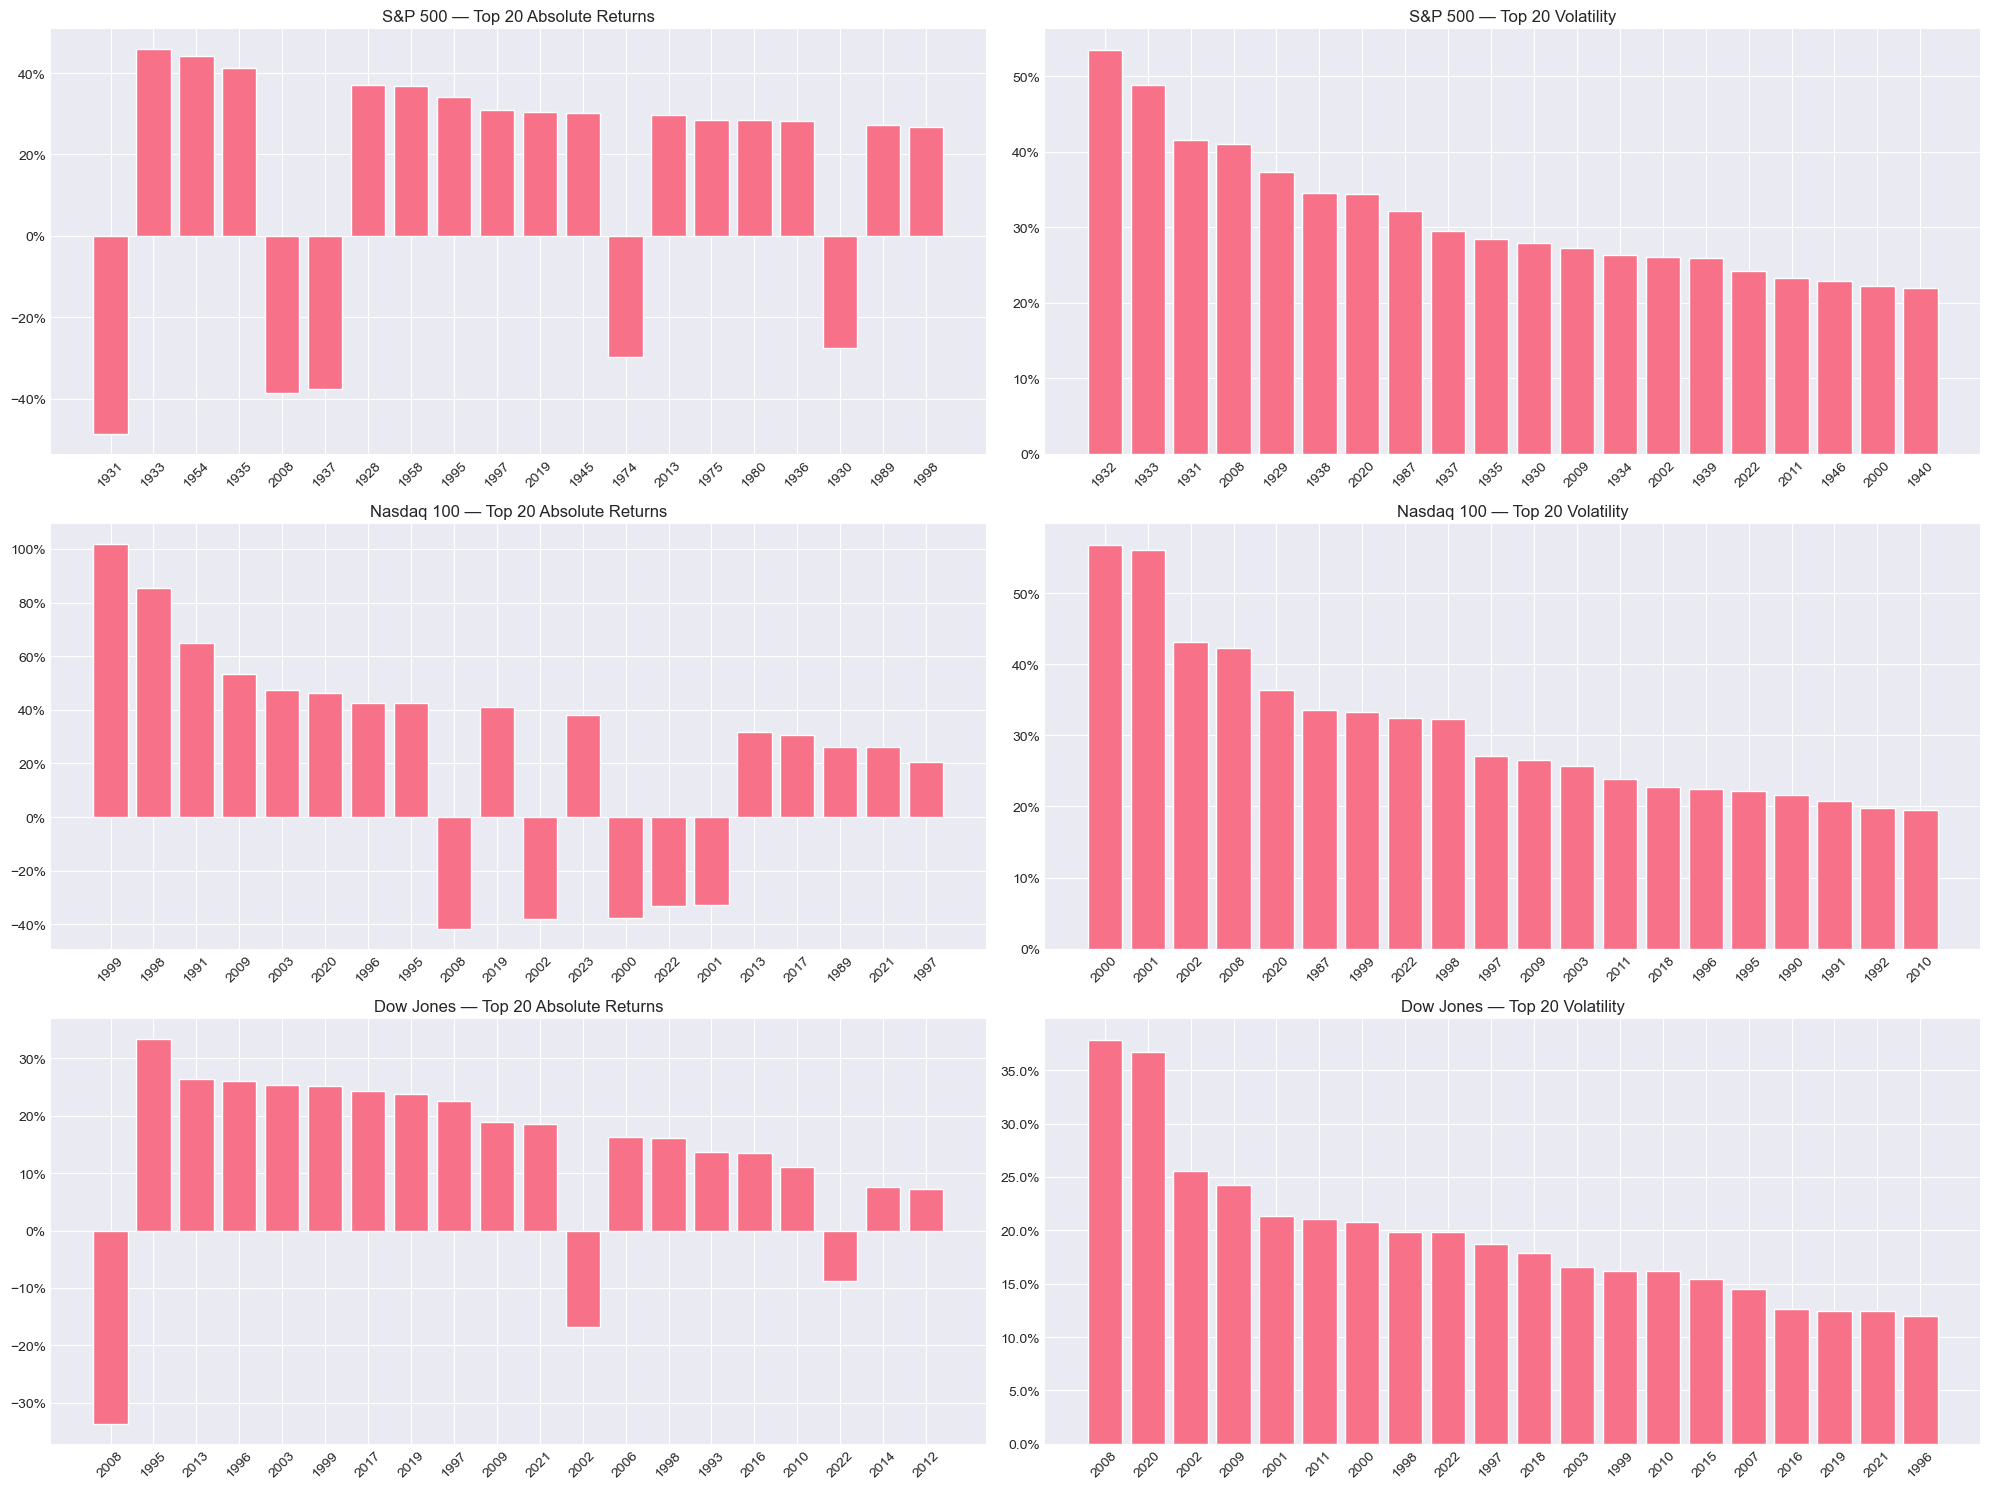

In [456]:
top_n = 20

yearly_return = {}
yearly_volatility = {}

for name, idx in indeces.items():
    idx['Year'] = idx.index.year

    # (Dec 31 close - Jan 1 open) / Jan 1 open
    annual_return = {}
    for year, group in idx.groupby('Year'):
        if len(group) == 0:
            continue

        if group.iloc[0]['Open'] != 0:
            open_price = group.iloc[0]['Open']
        else:
            open_price = group.iloc[0]['Close']

        close_price = group.iloc[-1]['Close']

        if pd.notna(open_price) and pd.notna(close_price):
            annual_return[year] = (close_price - open_price) / open_price

    annual_return = pd.Series(annual_return)
    annual_return = pd.Series(annual_return).dropna()

    #std of daily returns * sqrt(252)
    annual_vol = (idx.groupby('Year')['Return'].std() * (252**0.5)).dropna()

    yearly_return[name] = annual_return
    yearly_volatility[name] = annual_vol

# 3x2 bar plot
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

for i, idx_name in enumerate(yearly_return.keys()):
    top_return_years = yearly_return[idx_name].abs().sort_values(ascending=False).head(top_n).index
    top_returns = yearly_return[idx_name].loc[top_return_years]

    top_vol_years = yearly_volatility[idx_name].abs().sort_values(ascending=False).head(top_n).index
    top_vol = yearly_volatility[idx_name].loc[top_vol_years]

    ax = axs[i, 0]
    ax.bar(top_return_years.astype(str), top_returns.values)
    ax.set_title(f"{idx_name} — Top {top_n} Absolute Returns")
    ax.set_xticklabels(top_return_years.astype(str), rotation=45)
    ax.grid(True, axis='y')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    ax = axs[i, 1]
    ax.bar(top_vol_years.astype(str), top_vol.values)
    ax.set_title(f"{idx_name} — Top {top_n} Volatility")
    ax.set_xticklabels(top_vol_years.astype(str), rotation=45)
    ax.grid(True, axis='y')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.tight_layout()
plt.show()

compare ovenight move to intraday move

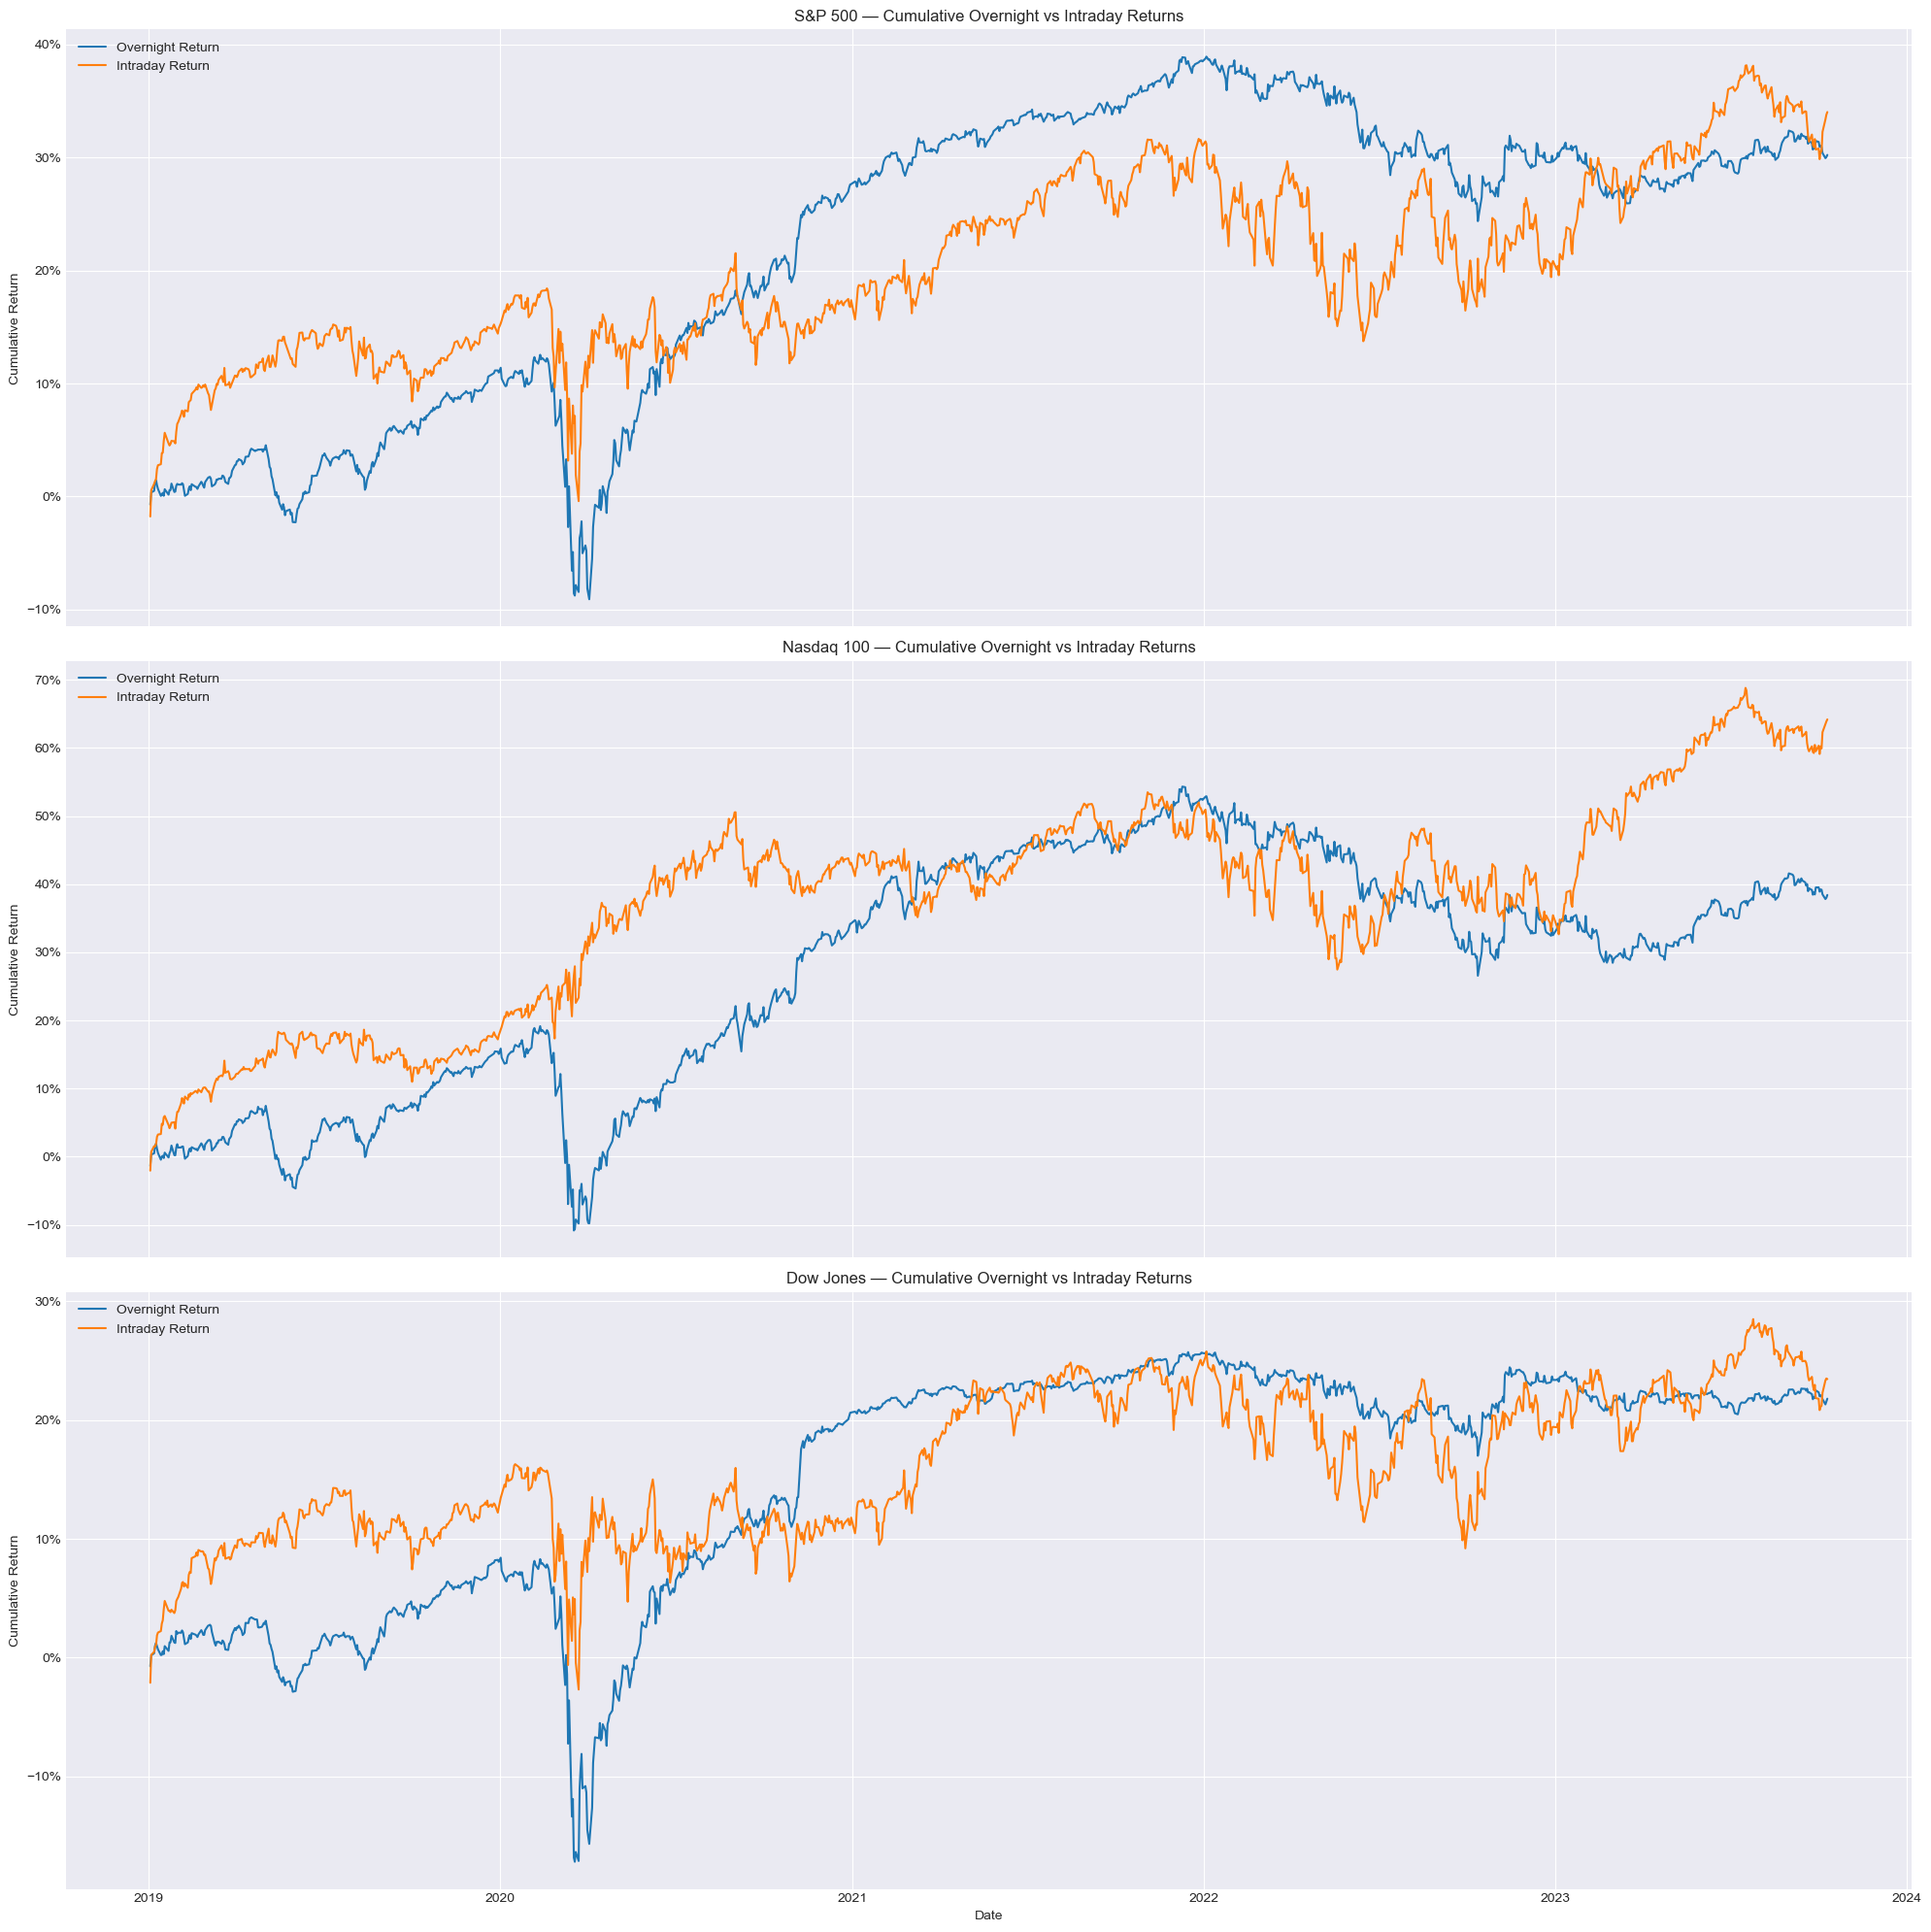

In [477]:
overnight_returns = {}
intraday_returns = {}

lookback_years = 5

for name, idx in indeces.items():
    df = idx

    all_years= df['Year'].unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df['Year'].isin(last_years)]

    df['PrevClose'] = df['Close'].shift(1)

    # Fix 0 Open prices: replace 0 with previous close if possible
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    # Drop rows where Open_fixed is still 0 or NaN
    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']


    overnight_returns[name] = df['OvernightReturn']
    intraday_returns[name] = df['IntradayReturn']

fig, axs = plt.subplots(len(indeces), 1, figsize=(20, 20), sharex=True)

for i, name in enumerate(indeces.keys()):
    ax = axs[i] if len(indeces) > 1 else axs

    # Plot cumulative returns for comparison
    ax.plot(overnight_returns[name].index, overnight_returns[name].cumsum(), label='Overnight Return', color='tab:blue')
    ax.plot(intraday_returns[name].index, intraday_returns[name].cumsum(), label='Intraday Return', color='tab:orange')

    ax.set_title(f"{name} — Cumulative Overnight vs Intraday Returns")
    ax.set_ylabel('Cumulative Return')
    ax.grid(True, axis='y')
    ax.legend()

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.xlabel('Date')
plt.tight_layout()
plt.show()



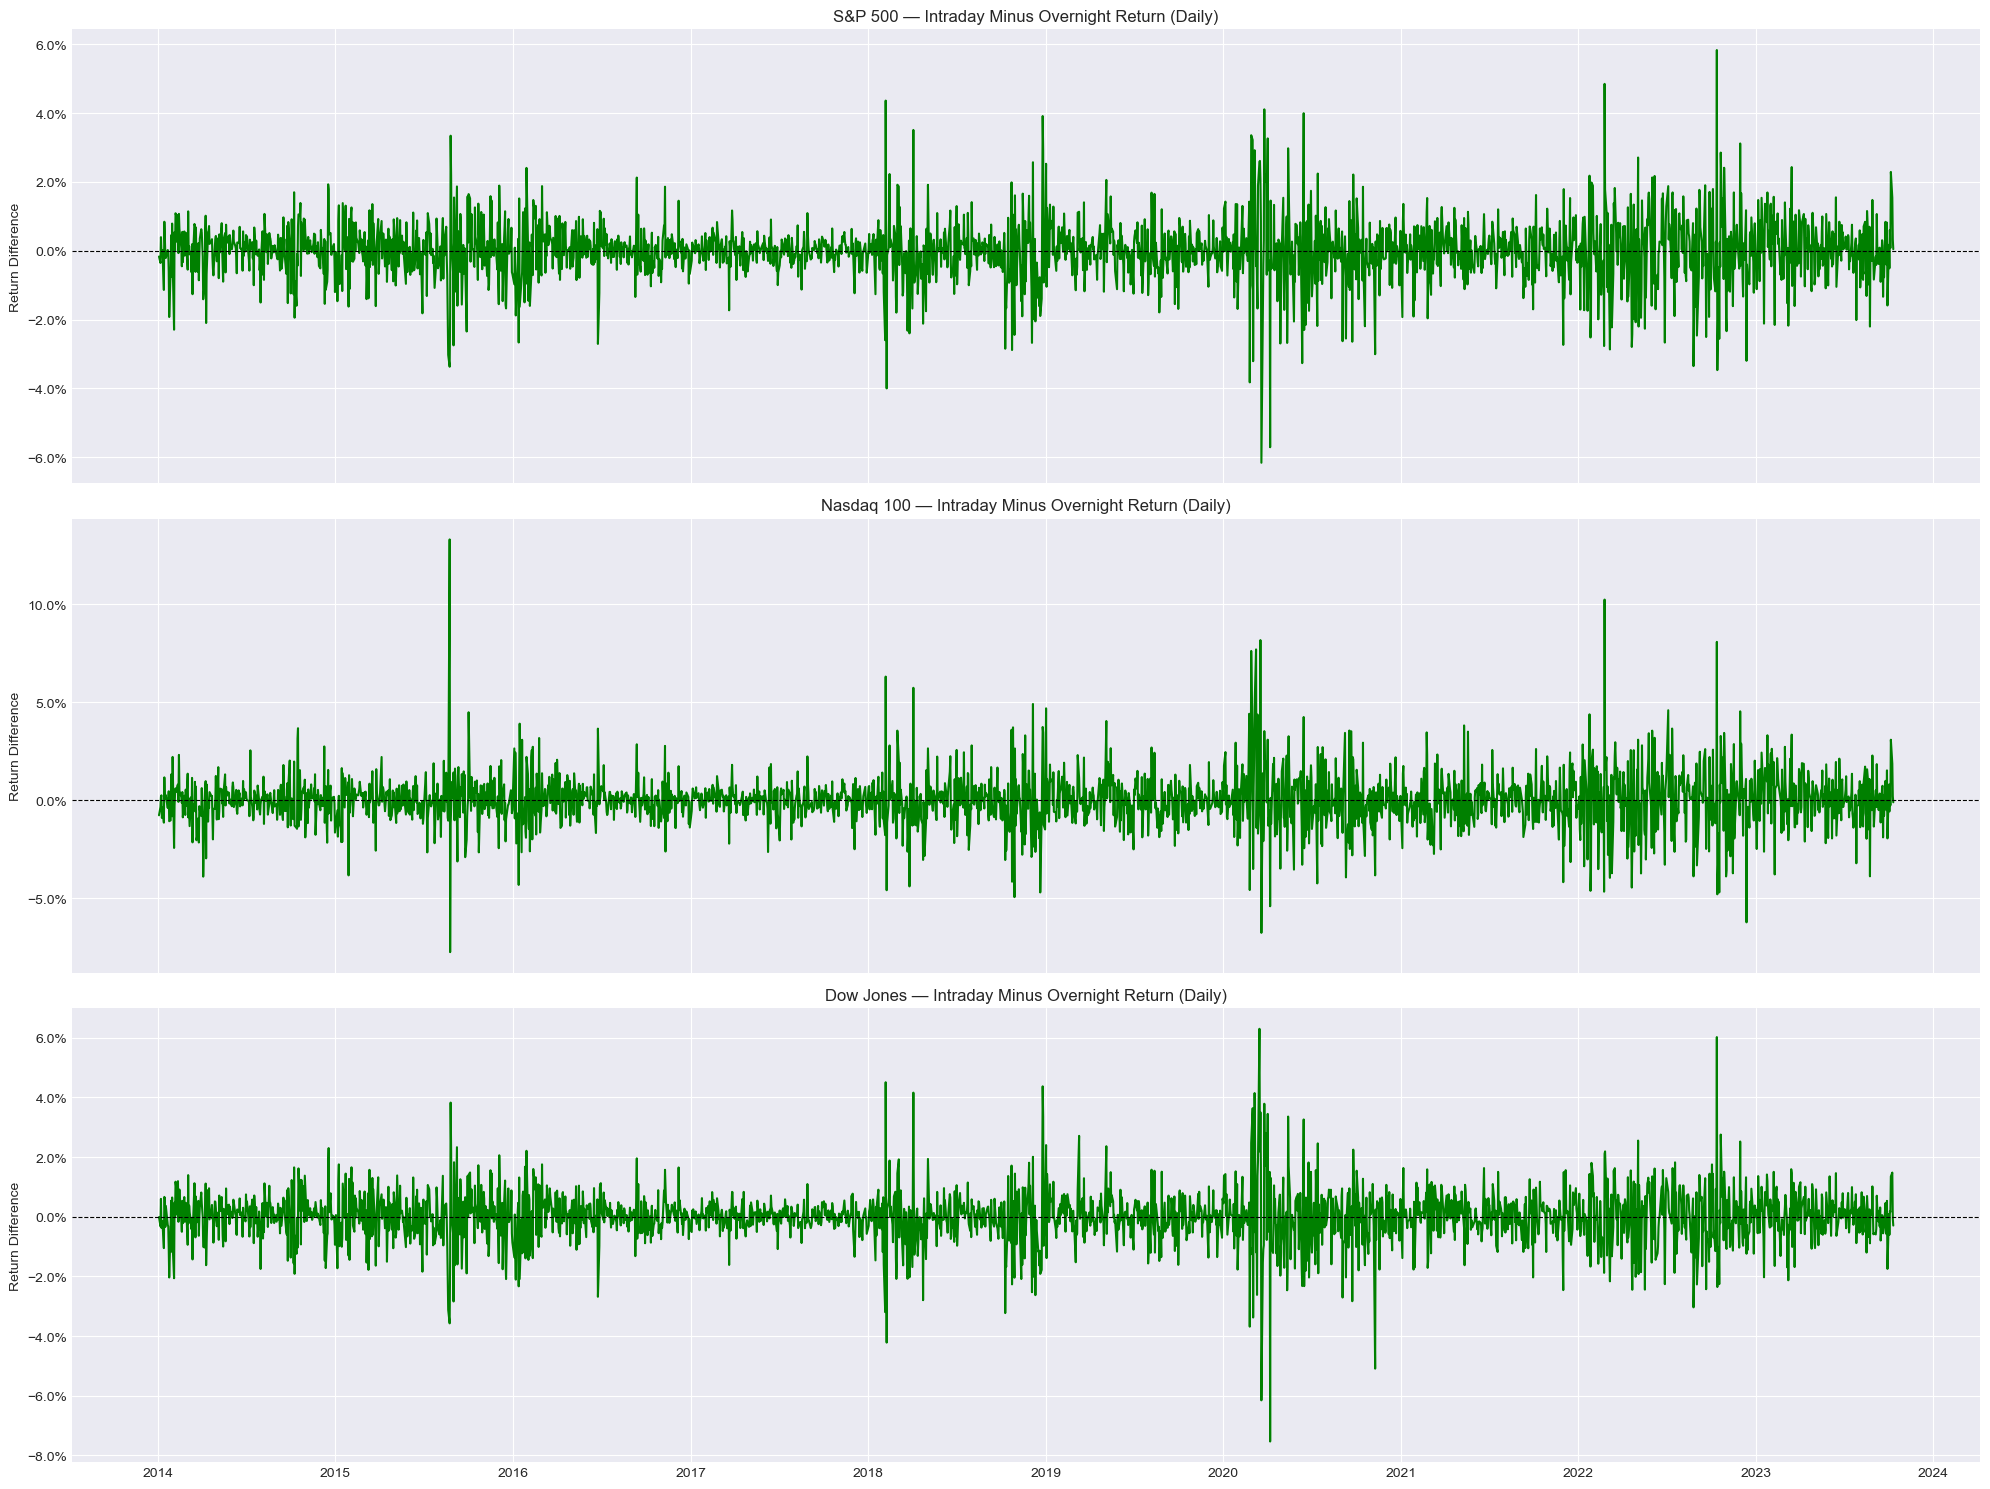

In [502]:
lookback_years = 10

return_diff = {}

for name, idx in indeces.items():
    df = idx.sort_index().copy()

    # Limit to last 'lookback_years'
    all_years = df['Year'].unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df['Year'].isin(last_years)]

    # Previous day's close
    df['PrevClose'] = df['Close'].shift(1)

    # Fix 0 Open prices
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    # Drop invalid rows
    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    # Returns
    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']

    # Difference
    return_diff[name] =  df['IntradayReturn'] - df['OvernightReturn']

fig, axs = plt.subplots(len(indeces), 1, figsize=(20,15), sharex=True)

for i, name in enumerate(indeces.keys()):
    ax_line = axs[i] if len(indeces) > 1 else axs

    ax_line.plot(return_diff[name].index, return_diff[name], color='green')
    ax_line.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax_line.set_title(f"{name} — Intraday Minus Overnight Return (Daily)")
    ax_line.set_ylabel('Return Difference')
    ax_line.grid(True, axis='y')
    ax_line.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))


plt.tight_layout()
plt.show()


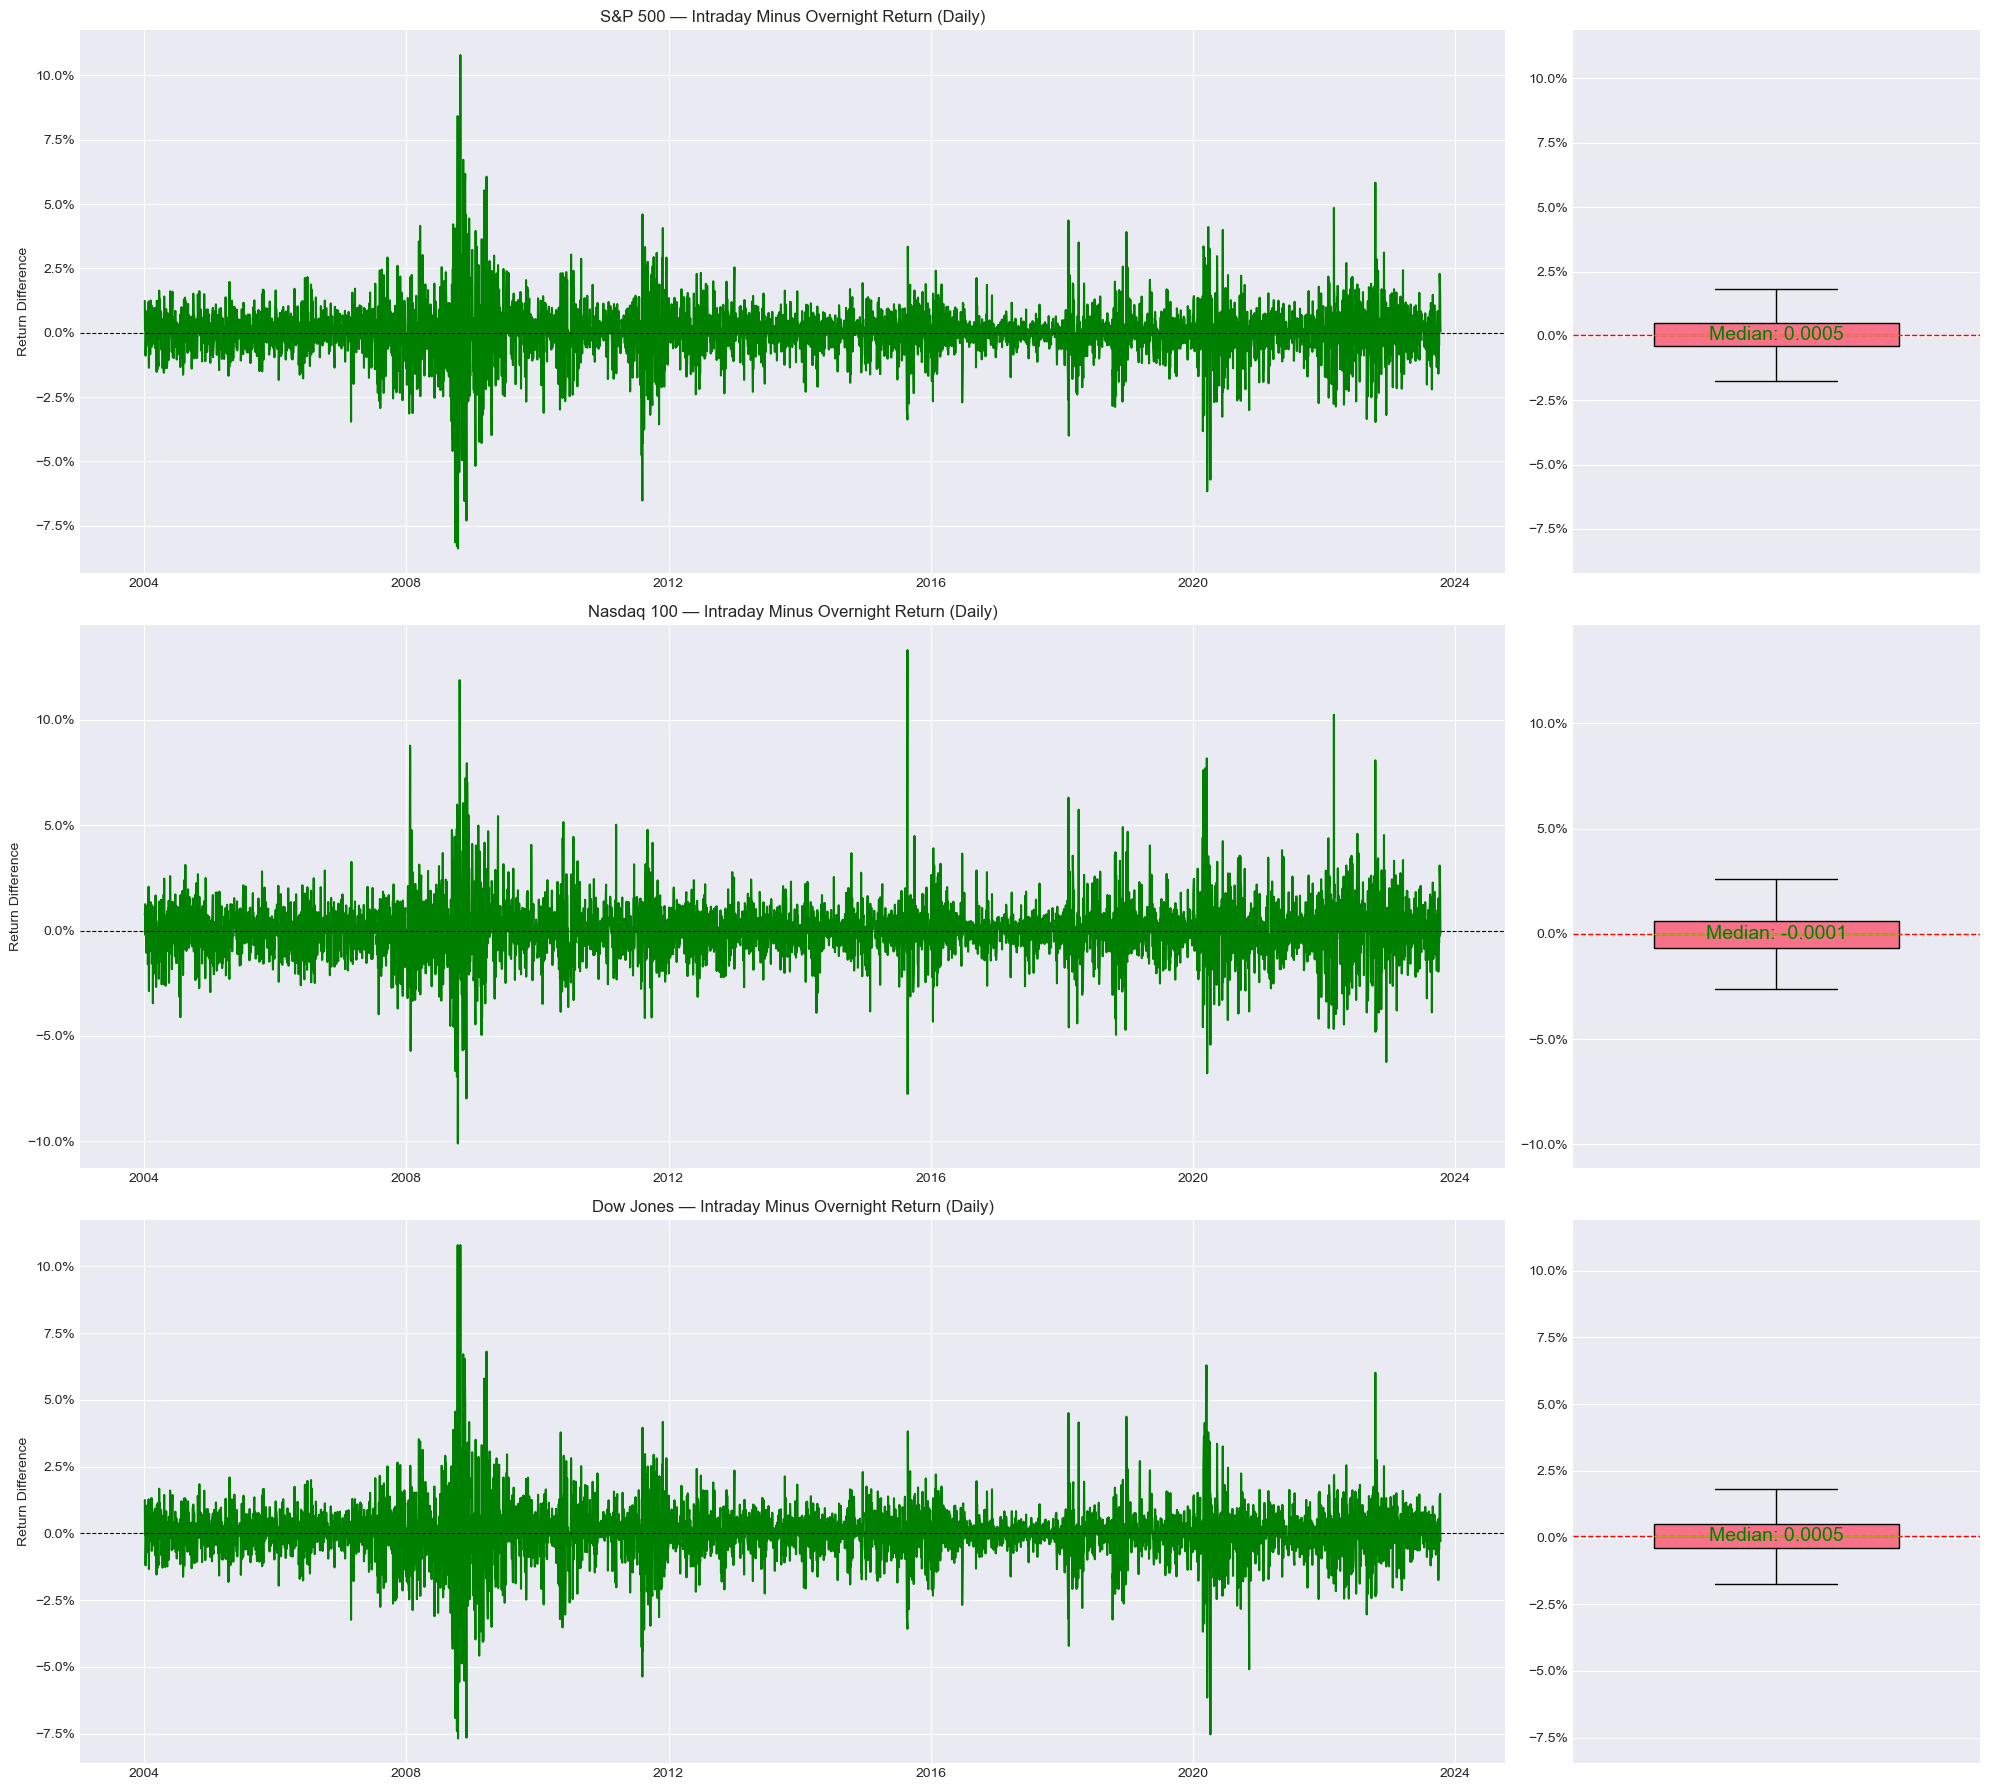

In [513]:
lookback_years = 20

return_diff = {}

for name, idx in indeces.items():
    df = idx.sort_index().copy()

    # Limit to last 'lookback_years'
    all_years = df['Year'].unique()
    last_years = all_years[-lookback_years:] if len(all_years) >= lookback_years else all_years
    df = df[df['Year'].isin(last_years)]

    # Previous day's close
    df['PrevClose'] = df['Close'].shift(1)

    # Fix 0 Open prices
    df['Open_fixed'] = df['Open']
    mask_zero = df['Open_fixed'] == 0
    df.loc[mask_zero, 'Open_fixed'] = df.loc[mask_zero, 'PrevClose']

    # Drop invalid rows
    df = df.dropna(subset=['Open_fixed', 'PrevClose', 'Close'])
    df = df[df['Open_fixed'] != 0]

    # Returns
    df['OvernightReturn'] = (df['Open_fixed'] - df['PrevClose']) / df['PrevClose']
    df['IntradayReturn'] = (df['Close'] - df['Open_fixed']) / df['Open_fixed']

    # Difference
    return_diff[name] =  df['IntradayReturn'] - df['OvernightReturn']

# Create a figure with two subplots per index: line chart + boxplot
fig, axs = plt.subplots(len(indeces), 2, figsize=(20, 6*len(indeces)),
                        gridspec_kw={'width_ratios': [7, 2]}, sharey=False)

for i, name in enumerate(indeces.keys()):
    ax_line = axs[i, 0]
    ax_box = axs[i, 1]

    # Daily difference line chart (left)
    ax_line.plot(return_diff[name].index, return_diff[name], color='green')
    ax_line.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax_line.set_title(f"{name} — Intraday Minus Overnight Return (Daily)")
    ax_line.set_ylabel('Return Difference')
    ax_line.grid(True, axis='y')
    ax_line.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Vertical boxplot (right)
    ax_box.boxplot(return_diff[name].values, vert=True, patch_artist=True, widths=0.6, showfliers=False)
    ax_box.set_xticks([])
    ax_box.set_xlabel('')
    ax_box.set_ylabel('')
    ax_box.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax_box.grid(True, axis='y')

    median_val = return_diff[name].median()
    ax_box.axhline(median_val, color='red', linestyle='--', linewidth=1)
    ax_box.text(1, median_val, f"Median: {median_val:.4f}", color='green',
            va='center', ha='center', fontsize=14)
    ax_box.set_ylim(return_diff[name].min()*1.1, return_diff[name].max()*1.1)  # expand vertical space

plt.tight_layout()
plt.show()


volatility clustering
